In [1]:
import json
import matplotlib.pyplot as plt
import jax
from jax import random, lax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, ELBO, Trace_ELBO
from numpyro.infer import MCMC, NUTS, HMC, DiscreteHMCGibbs, MixedHMC
from numpyro.infer import Predictive
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm
from numpyro.ops.indexing import Vindex
from numpyro.infer import Predictive
import itertools

import scipy
import arviz as az
from scipy.optimize import minimize

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pickle
data_folder = os.path.join("data")
figpath = os.path.join("figures")
modelpath = os.path.join("modelfits")

import jaxopt
from functools import partial
import scipy
import seaborn as sns


import scipy.io
from scipy.interpolate import CubicSpline
# mat = scipy.io.loadmat('exps_all.mat')["exps"]
mat = scipy.io.loadmat(os.path.join(data_folder,'exps_all_rewardmag75perc.mat'))["exps"] # 75% transform of the low reward condition in rewardmag experiment (ad hoc)
colors = ["C3","C2","C0"]
dataset_names = ["exp_ITI","exp_Ns246","exp_Ns267","exp_rewardmag"]
cond_names = [["ITI = 0s","ITI = 0.5s","ITI = 2s"],["Set size 2","Set size 4","Set size 6"],["Set size 2","Set size 6","Set size 7"],["Reward low","Reward high"]]

# Colormaps for each experiment
colormaps = {}
cmap_set1 = plt.get_cmap('Set1')
cmap_set2 = plt.get_cmap('Set2')
cmap_set3 = plt.get_cmap('Set3')
colors_set1 = cmap_set1(range(10))
colors_set2 = cmap_set2(range(10))
colors_set3 = cmap_set3(range(10))
colormaps["exp_ITI"] = colors_set1[[0,2,1],:]
colormaps["exp_Ns246"] = colors_set2[[1,0,2],:]
colormaps["exp_Ns267"] = np.concatenate((colormaps["exp_Ns246"][[0,2],:], colors_set1[3:4,:]))
colormaps["exp_rewardmag"] = colors_set2[3:5,:]


cmap_models = plt.get_cmap('tab10')
colors_models = cmap_models(range(10))
colors_models = colors_models[[5,8,9],:]
model_markers = [".", "^", "*"]

C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load datasets

exp_ITI
exp_Ns246
exp_Ns267
exp_rewardmag


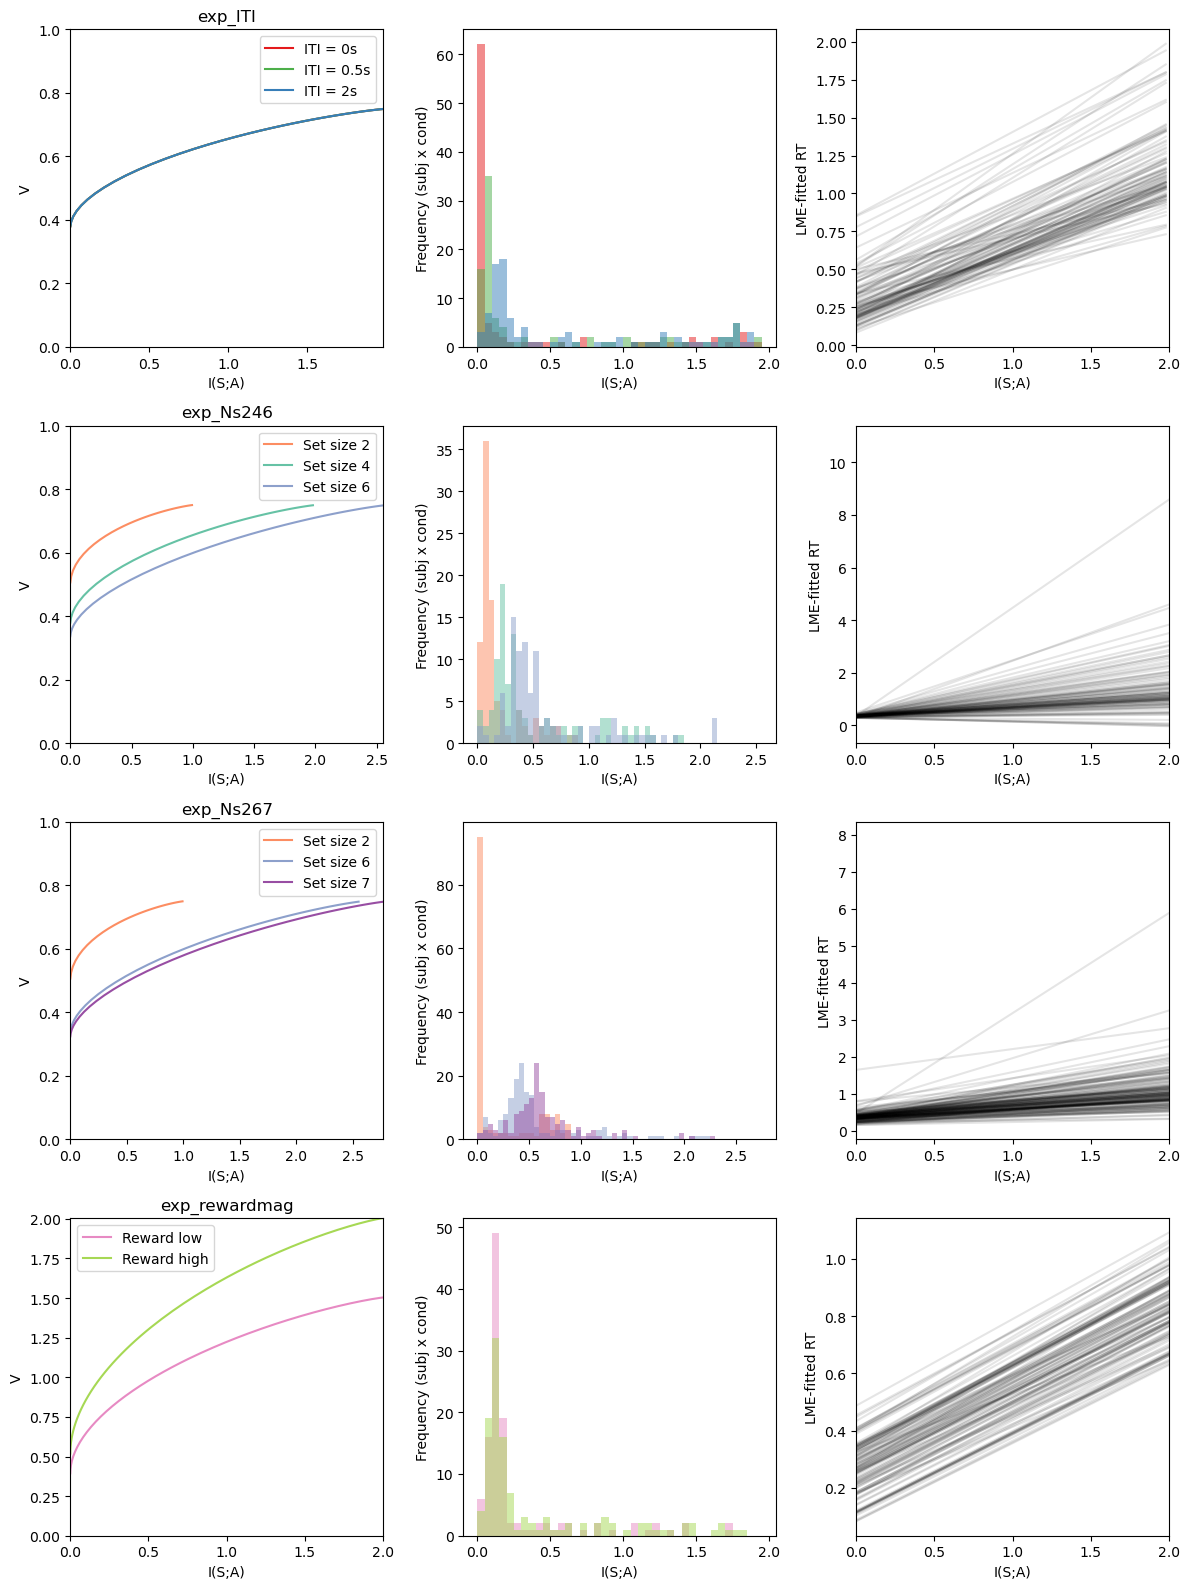

In [2]:
datasets_dict = {};
n_subjs = np.zeros((len(dataset_names)))
r_grid_nentries = 200;

fig,ax = plt.subplots(4,3,figsize=(12,16))
for dataset_idx in range(len(dataset_names)):
    dataset_name = dataset_names[dataset_idx]
    print(dataset_name)
    exp_mat = mat[dataset_name]
    
    dataset_dict = {}

    ITIs = exp_mat[0,0][0,0][0][0]
    complexity = jnp.array(exp_mat[0,0][0,0][2][0,0][4])
    if(dataset_idx==0):
        complexity_allexps = complexity
    elif(not("reward" in dataset_name)):
        complexity_allexps = np.concatenate((complexity_allexps, complexity),axis=0)
    fixedrandomeffects = jnp.array(exp_mat[0,0][0,0][3][0,0][2])[:,1:] # Col1 is b, Col2 is k, Rows are subjs. Fitted LME predicts RT = k*I + b for each subject.
    [n_subj,n_cond] = complexity.shape
    n_subjs[dataset_idx] = n_subj
    
    p_state = {}; Q = {}; R = {}; V = {};
    R_grid = {}; V_grid = {}; V_R_splines = {};
    
    if("ITI" in dataset_name):
        for cond in range(n_cond):
            cond_name = cond_names[dataset_idx][cond]
            p_state[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][1].flatten())
            Q[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][0])
            R[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][2].flatten())
            V[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][3].flatten())
            spl = CubicSpline(R[cond_name], V[cond_name])
            V_R_splines[cond_name] = spl
            R_grid[cond_name] = jnp.linspace(0,jnp.max(R[cond_name]), r_grid_nentries)
            V_grid[cond_name] = spl(R_grid[cond_name])
    elif("Ns" in dataset_name):
        for cond in range(n_cond):
            cond_name = cond_names[dataset_idx][cond]
            p_state[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][1][0,0][cond][0])
            Q[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][0][0,0][cond])
            R[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][2][0,0][cond].flatten())
            V[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][3][0,0][cond].flatten())
            spl = CubicSpline(R[cond_name], V[cond_name])
            V_R_splines[cond_name] = spl
            R_grid[cond_name] = jnp.linspace(0,jnp.max(R[cond_name]), r_grid_nentries)
            V_grid[cond_name] = spl(R_grid[cond_name])
    else:
        for cond in range(n_cond):
            cond_name = cond_names[dataset_idx][cond]
            p_state[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][1].flatten())
            Q[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][2][0,0][cond])
            R[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][3][0,0][cond].flatten())
            V[cond_name] = jnp.array(exp_mat[0,0][0,0][1][0,0][4][0,0][cond].flatten())
            V_R_splines[cond_name] = np.nan
            R_grid[cond_name] = R[cond_name]
            V_grid[cond_name] = V[cond_name]
        

        
    dataset_dict = {"cond_names":cond_names[dataset_idx],"ITIs":ITIs, "Q":Q, "p_state":p_state,"R":R,"V":V,"R_grid":R_grid,"V_grid":V_grid,"V_R_splines":V_R_splines, "complexity":complexity,"n_subj":n_subj,"n_cond":n_cond, "fixedrandomeffects":fixedrandomeffects}
    datasets_dict[dataset_name] = dataset_dict
    
    # Visualize
    for cond in range(n_cond):
        ax[dataset_idx,0].plot(R[cond_names[dataset_idx][cond]],V[cond_names[dataset_idx][cond]],"-", color=colormaps[dataset_name][cond,:], label=cond_names[dataset_idx][cond])
#         if(not("reward" in dataset_name)):
#             r_grid = R_grid[cond_names[dataset_idx][cond]]
#             v_grid = V_grid[cond_names[dataset_idx][cond]]
#             ax[dataset_idx,0].plot(r_grid,v_grid,".-", color=colors[cond])

        
    ax[dataset_idx,0].set_xlim([0,max(1,jnp.max(R[cond_names[dataset_idx][cond]]))])
    ax[dataset_idx,0].set_ylim([0,max(1,jnp.max(V[cond_names[dataset_idx][cond]]))])
    ax[dataset_idx,0].set_xlabel("I(S;A)")
    ax[dataset_idx,0].set_ylabel("V")
    ax[dataset_idx,0].set_title(dataset_name)
    ax[dataset_idx,0].legend()

    for cond in range(n_cond):
        ax[dataset_idx,1].hist(complexity[:,cond], bins=jnp.arange(0,jnp.max(R[cond_names[dataset_idx][cond]]),0.05),color=colormaps[dataset_name][cond,:], alpha=0.5, label=cond_names[dataset_idx][cond])
        ax[dataset_idx,1].set_xlabel("I(S;A)")
        ax[dataset_idx,1].set_ylabel("Frequency (subj x cond)")

    for subj in range(n_subj):
        ax[dataset_idx,2].plot(R[cond_names[dataset_idx][-1]],fixedrandomeffects[subj,0] + fixedrandomeffects[subj,1]*R[cond_names[dataset_idx][-1]], color="k", alpha=0.1)
        ax[dataset_idx,2].set_xlabel("I(S;A)")
        ax[dataset_idx,2].set_ylabel("LME-fitted RT")
        ax[dataset_idx,2].set_xlim([0,2])
fig.tight_layout()
plt.savefig(os.path.join(figpath, "exps_all_rewardmag75perc.png"), dpi=300)
plt.show()

## Model

In [3]:
def find_optimal_policycomplexity_orig(dataset_dict, subj):
    '''This code assume reward-RATE maximization. Not suitable for exp_rewardmag!'''
    [n_subj,n_cond] = dataset_dict["complexity"].shape
    cond_names = dataset_dict["cond_names"]
    ITIs = dataset_dict["ITIs"]
    optimal_complexity = jnp.zeros((1,n_cond))
    fixedrandomeffect = dataset_dict["fixedrandomeffects"][subj,:]
    
    if(np.isnan(ITIs[0])): # Reward magnitude experiment
        compute_reward_insteadof_timeavgrwd = True
    else:
        compute_reward_insteadof_timeavgrwd = False
        
    for cond in range(n_cond):
        r_grid = dataset_dict["R_grid"][cond_names[cond]]
        v_grid = dataset_dict["V_grid"][cond_names[cond]]
        if(compute_reward_insteadof_timeavgrwd):
            rewardrates_memorysensitive = v_grid
        else:
            rewardrates_memorysensitive = v_grid/(fixedrandomeffect[0]+fixedrandomeffect[1]*r_grid + ITIs[cond])

        # Use jnp.argmax and ensure consistency
        max_idx = jnp.argmax(rewardrates_memorysensitive)  # Returns a tracer during tracing
        max_val = r_grid[max_idx]  # Index r_grid with the tracer
        # Update the optimal_complexity_expITI array (in a JAX-compatible way)
        optimal_complexity = optimal_complexity.at[0,cond].set(max_val)

    return optimal_complexity

# find_optimal_policycomplexity(datasets_dict["exp_ITI"], 0.3*np.ones((97,)))

In [4]:
def find_optimal_policycomplexity_linear(dataset_dict, k_ind, subj):
    '''This code assume reward-RATE maximization. Not suitable for exp_rewardmag!'''
    [n_subj,n_cond] = dataset_dict["complexity"].shape
    cond_names = dataset_dict["cond_names"]
    ITIs = dataset_dict["ITIs"]
    optimal_complexity = jnp.zeros((1,n_cond))
    fixedrandomeffect = dataset_dict["fixedrandomeffects"][subj,:]
    if(np.isnan(ITIs[0])): # Reward magnitude experiment
        compute_reward_insteadof_timeavgrwd = True
    else:
        compute_reward_insteadof_timeavgrwd = False
        
    for cond in range(n_cond):
        r_grid = dataset_dict["R_grid"][cond_names[cond]]
        v_grid = dataset_dict["V_grid"][cond_names[cond]]
        if(compute_reward_insteadof_timeavgrwd):
            rewardrates_memorysensitive = (v_grid - k_ind*r_grid)
        else:
            rewardrates_memorysensitive = (v_grid - k_ind*r_grid)/(fixedrandomeffect[0]+fixedrandomeffect[1]*r_grid + ITIs[cond])
        #rewardrates_memorysensitive = (v_grid)/(fixedrandomeffect[0]+fixedrandomeffect[1]*r_grid + ITIs[cond])  - k_ind[subj]*r_grid


        # Use jnp.argmax and ensure consistency
        max_idx = jnp.argmax(rewardrates_memorysensitive)  # Returns a tracer during tracing
        max_val = r_grid[max_idx]  # Index r_grid with the tracer
        # Update the optimal_complexity_expITI array (in a JAX-compatible way)
        optimal_complexity = optimal_complexity.at[0,cond].set(max_val)

    return optimal_complexity

# find_optimal_policycomplexity(datasets_dict["exp_ITI"], 0.3*np.ones((97,)))

In [5]:
def find_optimal_policycomplexity_quadratic(dataset_dict, k_ind, quad_ind, subj):
    '''This code assume reward-RATE maximization. Not suitable for exp_rewardmag!'''
    [n_subj,n_cond] = dataset_dict["complexity"].shape
    cond_names = dataset_dict["cond_names"]
    ITIs = dataset_dict["ITIs"]
    optimal_complexity = jnp.zeros((1,n_cond))
    fixedrandomeffect = dataset_dict["fixedrandomeffects"][subj,:]
    if(np.isnan(ITIs[0])): # Reward magnitude experiment
        compute_reward_insteadof_timeavgrwd = True
    else:
        compute_reward_insteadof_timeavgrwd = False
        
    for cond in range(n_cond):
        r_grid = dataset_dict["R_grid"][cond_names[cond]]
        v_grid = dataset_dict["V_grid"][cond_names[cond]]
        if(compute_reward_insteadof_timeavgrwd):
            rewardrates_memorysensitive = (v_grid - k_ind*r_grid - quad_ind*r_grid*r_grid)
        else:
            rewardrates_memorysensitive = (v_grid - k_ind*r_grid - quad_ind*r_grid*r_grid)/(fixedrandomeffect[0]+fixedrandomeffect[1]*r_grid + ITIs[cond])
        #rewardrates_memorysensitive = (v_grid)/(fixedrandomeffect[0]+fixedrandomeffect[1]*r_grid + ITIs[cond])  - k_ind[subj]*r_grid


        # Use jnp.argmax and ensure consistency
        max_idx = jnp.argmax(rewardrates_memorysensitive)  # Returns a tracer during tracing
        max_val = r_grid[max_idx]  # Index r_grid with the tracer
        # Update the optimal_complexity_expITI array (in a JAX-compatible way)
        optimal_complexity = optimal_complexity.at[0,cond].set(max_val)

    return optimal_complexity

# find_optimal_policycomplexity(datasets_dict["exp_ITI"], 0.3*np.ones((97,)))

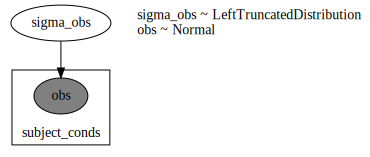

In [6]:
# Default: not fit the exp_rewardmag dataset.
def model_orig(training=True, dataset_name = "exp_ITI", subj = 0):
    dataset_dict = datasets_dict[dataset_name]
    complexity_subj_allconds = dataset_dict["complexity"][subj,:]
    
    # 2) Individual-level memory cost slope
    sigma_obs = numpyro.sample("sigma_obs", dist.TruncatedCauchy(loc=0, scale=1, low=0))  # Observation noise parameter

    optimal_complexity_subj_allconds = find_optimal_policycomplexity_orig(dataset_dict, subj)
    optimal_complexity_flat = optimal_complexity_subj_allconds.flatten()
    complexity_flat = complexity_subj_allconds.flatten()
    
    # 4) Loss computation
    size = int(optimal_complexity_flat.shape[0])  # Convert to concrete Python integer
    assert size > 0, "size of plate should be positive"

    with numpyro.plate("subject_conds", size):  # Assuming optimal_complexity is 100x3
        if(training):
            numpyro.sample(
                "obs", 
                dist.Normal(optimal_complexity_flat, sigma_obs),  # Multivariate normal assumption
                obs=complexity_flat  # Observed values
            )
        else:
            numpyro.sample(
                "obs", 
                dist.Normal(optimal_complexity_flat, sigma_obs),  # Multivariate normal assumption
            )

key = random.PRNGKey(1)
# with handlers.seed(rng_seed=47):  # random.PRNGKey(47) is used
#     model()
numpyro.render_model(model_orig, render_distributions=True, render_params=True)


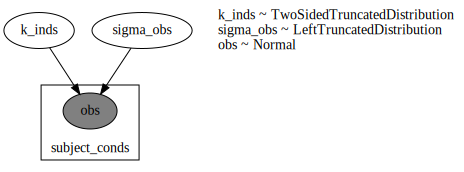

In [7]:
# Default: not fit the exp_rewardmag dataset.
def model_linear(training=True, dataset_name = "exp_ITI", subj = 0):
    dataset_dict = datasets_dict[dataset_name]
    complexity_subj_allconds = dataset_dict["complexity"][subj,:]
    
    # 2) Individual-level memory cost slope
    k_inds = numpyro.sample("k_inds", dist.TruncatedCauchy(loc=0, scale=1, low=-1,high=1)) # Normal(5, 3)
    sigma_obs = numpyro.sample("sigma_obs", dist.TruncatedCauchy(loc=0, scale=1, low=0))  # Observation noise parameter

    optimal_complexity_subj_allconds = find_optimal_policycomplexity_linear(dataset_dict, k_inds, subj)
    optimal_complexity_flat = optimal_complexity_subj_allconds.flatten()
    complexity_flat = complexity_subj_allconds.flatten()
    
    # 4) Loss computation
    size = int(optimal_complexity_flat.shape[0])  # Convert to concrete Python integer
    assert size > 0, "size of plate should be positive"

    with numpyro.plate("subject_conds", size):  # Assuming optimal_complexity is 100x3
        if(training):
            numpyro.sample(
                "obs", 
                dist.Normal(optimal_complexity_flat, sigma_obs),  # Multivariate normal assumption
                obs=complexity_flat  # Observed values
            )
        else:
            numpyro.sample(
                "obs", 
                dist.Normal(optimal_complexity_flat, sigma_obs),  # Multivariate normal assumption
            )

key = random.PRNGKey(1)
# with handlers.seed(rng_seed=47):  # random.PRNGKey(47) is used
#     model()
numpyro.render_model(model_linear, render_distributions=True, render_params=True)


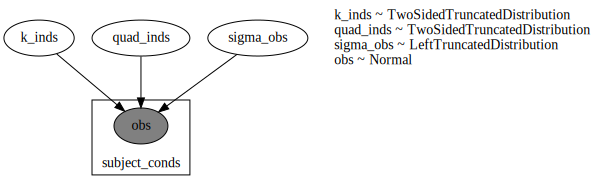

In [8]:
# Default: not fit the exp_rewardmag dataset.
def model_quadratic(training=True, dataset_name = "exp_ITI", subj = 0):
    dataset_dict = datasets_dict[dataset_name]
    complexity_subj_allconds = dataset_dict["complexity"][subj,:]
    
    # 2) Individual-level memory cost slope
    k_inds = numpyro.sample("k_inds", dist.TruncatedCauchy(loc=0, scale=1, low=-1,high=1)) # Normal(5, 3)
    quad_inds = numpyro.sample("quad_inds", dist.TruncatedCauchy(loc=0, scale=1, low=-1,high=1)) # Normal(5, 3)
    sigma_obs = numpyro.sample("sigma_obs", dist.TruncatedCauchy(loc=0, scale=1, low=0))  # Observation noise parameter

    optimal_complexity_subj_allconds = find_optimal_policycomplexity_quadratic(dataset_dict, k_inds, quad_inds, subj)
    optimal_complexity_flat = optimal_complexity_subj_allconds.flatten()
    complexity_flat = complexity_subj_allconds.flatten()
    
    # 4) Loss computation
    size = int(optimal_complexity_flat.shape[0])  # Convert to concrete Python integer
    assert size > 0, "size of plate should be positive"

    with numpyro.plate("subject_conds", size):  # Assuming optimal_complexity is 100x3
        if(training):
            numpyro.sample(
                "obs", 
                dist.Normal(optimal_complexity_flat, sigma_obs),  # Multivariate normal assumption
                obs=complexity_flat  # Observed values
            )
        else:
            numpyro.sample(
                "obs", 
                dist.Normal(optimal_complexity_flat, sigma_obs),  # Multivariate normal assumption
            )

key = random.PRNGKey(1)
# with handlers.seed(rng_seed=47):  # random.PRNGKey(47) is used
#     model()
numpyro.render_model(model_quadratic, render_distributions=True, render_params=True)


In [10]:
for dataset_name in dataset_names:
    [n_subj,n_cond] = datasets_dict[dataset_name]["complexity"].shape
    if(dataset_name=="exp_ITI"):
        start_subj = 0
    else:
        start_subj = 0
    
    for subj in range(start_subj, n_subj):
        print("Dataset",dataset_name, ", Subject",subj)
        # Initialize the RNG key for reproducibility
        rng_key = random.PRNGKey(0)
        # Set up the NUTS sampler
        nuts_kernel = NUTS(model_orig)
        # Configure the MCMC sampler
        mcmc = MCMC(
            nuts_kernel,
            num_warmup=2000,  # Number of warm-up steps
            num_samples=2000,  # Number of samples to collect
            num_chains=4,  # Number of parallel chains
            progress_bar=True,  # Display a progress bar
        )
        # Run the MCMC sampler
        mcmc.run(rng_key, dataset_name=dataset_name, subj=subj)
        # Collect the results
        posterior_samples = mcmc.get_samples()
        # Summary of results
        mcmc.print_summary()
        # Save the posterior samples to a file
        with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_m0.pkl"), "wb") as f:
            a = {"posterior_samples":posterior_samples,"mcmc":mcmc}
            pickle.dump(a, f)


Dataset exp_ITI , Subject 0


C:\Users\liu_s\AppData\Local\Temp\ipykernel_3152\2025553287.py:15: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


KeyboardInterrupt: 

In [75]:
for dataset_name in [dataset_names[3]]:
    [n_subj,n_cond] = datasets_dict[dataset_name]["complexity"].shape
    if(dataset_name=="exp_ITI"):
        start_subj = 0
    else:
        start_subj = 0
    
    for subj in range(start_subj, n_subj):
        print("Dataset",dataset_name, ", Subject",subj)
        
        # Orig model
        # Initialize the RNG key for reproducibility
        rng_key = random.PRNGKey(0)
        # Set up the NUTS sampler
        nuts_kernel = NUTS(model_orig)
        # Configure the MCMC sampler
        mcmc = MCMC(
            nuts_kernel,
            num_warmup=2000,  # Number of warm-up steps
            num_samples=2000,  # Number of samples to collect
            num_chains=4,  # Number of parallel chains
            progress_bar=True,  # Display a progress bar
        )
        # Run the MCMC sampler
        mcmc.run(rng_key, dataset_name=dataset_name, subj=subj)
        # Collect the results
        posterior_samples = mcmc.get_samples()
        # Summary of results
        mcmc.print_summary()
        # Save the posterior samples to a file
        with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_m0.pkl"), "wb") as f:
            a = {"posterior_samples":posterior_samples,"mcmc":mcmc}
            pickle.dump(a, f)
        
        
        
        
        
        # Linear model
        # Initialize the RNG key for reproducibility
        rng_key = random.PRNGKey(0)
        # Set up the NUTS sampler
        nuts_kernel = NUTS(model_linear)
        # Configure the MCMC sampler
        mcmc = MCMC(
            nuts_kernel,
            num_warmup=2000,  # Number of warm-up steps
            num_samples=2000,  # Number of samples to collect
            num_chains=4,  # Number of parallel chains
            progress_bar=True,  # Display a progress bar
        )
        # Run the MCMC sampler
        mcmc.run(rng_key, dataset_name=dataset_name, subj=subj)
        # Collect the results
        posterior_samples = mcmc.get_samples()
        # Summary of results
        mcmc.print_summary()
        # Save the posterior samples to a file
        with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_m1.pkl"), "wb") as f:
            a = {"posterior_samples":posterior_samples,"mcmc":mcmc}
            pickle.dump(a, f)
        
        
        
        
        # Quadratic model
        # Initialize the RNG key for reproducibility
        rng_key = random.PRNGKey(0)
        # Set up the NUTS sampler
        nuts_kernel = NUTS(model_quadratic)
        # Configure the MCMC sampler
        mcmc = MCMC(
            nuts_kernel,
            num_warmup=2000,  # Number of warm-up steps
            num_samples=2000,  # Number of samples to collect
            num_chains=4,  # Number of parallel chains
            progress_bar=True,  # Display a progress bar
        )
        # Run the MCMC sampler
        mcmc.run(rng_key, dataset_name=dataset_name, subj=subj)
        # Collect the results
        posterior_samples = mcmc.get_samples()
        # Summary of results
        mcmc.print_summary()
        # Save the posterior samples to a file
        with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_m2.pkl"), "wb") as f:
            a = {"posterior_samples":posterior_samples,"mcmc":mcmc}
            pickle.dump(a, f)



C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


Dataset exp_rewardmag , Subject 48


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 2790.55it/s, 1 steps of size 7.02e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.28      1.50      1.88      0.75      3.76   1960.90      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 418.84it/s, 1023 steps of size 1.65e-03. acc. prob=0.77]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.68      0.40      0.81      0.19      1.00     96.13      1.04
  sigma_obs      0.87      1.06      0.50      0.08      2.00    113.77      1.03

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 291.88it/s, 1023 steps of size 4.08e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.50      0.39      0.58     -0.08      1.00    119.57      1.03
  quad_inds      0.58      0.30      0.62      0.18      1.00     86.86      1.07
  sigma_obs      0.50      0.66      0.32      0.04      0.98    187.66      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 49


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3190.92it/s, 7 steps of size 6.68e-01. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.11      1.38      1.73      0.71      3.60   1718.82      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 442.25it/s, 1023 steps of size 1.74e-03. acc. prob=0.75]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.62      0.42      0.76     -0.06      1.00     58.49      1.06
  sigma_obs      0.88      1.07      0.50      0.09      1.95     47.98      1.07

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 289.91it/s, 1023 steps of size 4.40e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.33      0.42      0.36     -0.26      0.99    167.47      1.03
  quad_inds      0.55      0.31      0.59      0.13      1.00    130.30      1.06
  sigma_obs      0.55      0.70      0.37      0.09      1.05    177.31      1.01

Number of divergences: 0
Dataset exp_rewardmag , Subject 50


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3143.46it/s, 1 steps of size 7.67e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.32      1.47      1.92      0.79      3.92   1847.03      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 429.96it/s, 1023 steps of size 1.77e-03. acc. prob=0.76]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.67      0.39      0.80      0.18      1.00    167.16      1.02
  sigma_obs      0.92      1.06      0.57      0.10      2.01    156.19      1.02

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 291.59it/s, 1023 steps of size 5.34e-04. acc. prob=0.91]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.48      0.40      0.57     -0.09      1.00    133.02      1.02
  quad_inds      0.55      0.32      0.60      0.14      1.00     63.31      1.09
  sigma_obs      0.56      0.77      0.37      0.04      1.12    189.88      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 51


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3254.39it/s, 1 steps of size 8.17e-01. acc. prob=0.91]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      0.50      0.47      0.36      0.10      0.94   1877.46      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:09<00:00, 431.87it/s, 511 steps of size 1.56e-03. acc. prob=0.85]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds     -0.09      0.38      0.03     -0.80      0.34     16.99      1.09
  sigma_obs      0.43      0.47      0.31      0.03      0.87    794.96      1.01

Number of divergences: 3


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 303.17it/s, 1023 steps of size 3.23e-05. acc. prob=0.88]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds     -0.26      0.27     -0.26     -0.70      0.18      9.39      1.30
  quad_inds      0.09      0.16      0.12     -0.20      0.34     12.28      1.30
  sigma_obs      0.14      0.23      0.05      0.00      0.38      4.35      1.42

Number of divergences: 0
Dataset exp_rewardmag , Subject 52


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3345.57it/s, 1 steps of size 8.04e-01. acc. prob=0.91]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.23      0.95      0.99      0.39      2.12   1521.97      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:02<00:00, 1735.33it/s, 63 steps of size 2.30e-02. acc. prob=0.87]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.07      0.50      0.17     -0.85      0.76   3192.40      1.00
  sigma_obs      1.12      0.84      0.90      0.28      1.95   2550.71      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:09<00:00, 410.11it/s, 255 steps of size 5.39e-03. acc. prob=0.78]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds     -0.18      0.50     -0.21     -1.00      0.53    164.88      1.02
  quad_inds      0.17      0.46      0.27     -0.61      0.93    457.68      1.01
  sigma_obs      0.91      0.71      0.73      0.21      1.66    223.69      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 53


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3387.04it/s, 1 steps of size 7.08e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.32      1.57      1.89      0.76      3.90   1757.87      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:09<00:00, 439.87it/s, 511 steps of size 2.58e-03. acc. prob=0.71]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.70      0.39      0.83      0.30      1.00    163.90      1.02
  sigma_obs      0.83      1.03      0.49      0.08      1.88    183.27      1.02

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 304.18it/s, 1023 steps of size 2.02e-04. acc. prob=0.96]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.52      0.40      0.62     -0.05      1.00     63.09      1.05
  quad_inds      0.59      0.30      0.64      0.20      1.00     43.84      1.11
  sigma_obs      0.46      0.50      0.30      0.02      1.04    132.77      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 54


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3324.35it/s, 1 steps of size 7.20e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.35      1.58      1.92      0.76      3.99   1762.88      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:06<00:00, 639.69it/s, 383 steps of size 6.78e-03. acc. prob=0.69]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.65      0.42      0.80      0.04      1.00     73.87      1.04
  sigma_obs      0.99      1.19      0.57      0.09      2.29     62.54      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 309.42it/s, 1023 steps of size 3.65e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.48      0.40      0.57     -0.08      1.00     96.73      1.03
  quad_inds      0.54      0.33      0.60      0.12      1.00     51.46      1.10
  sigma_obs      0.58      0.66      0.38      0.04      1.20    106.26      1.04

Number of divergences: 0
Dataset exp_rewardmag , Subject 55


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 2782.23it/s, 1 steps of size 7.29e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.29      1.48      1.89      0.74      3.81   1757.84      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:06<00:00, 613.16it/s, 511 steps of size 6.94e-03. acc. prob=0.70]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.66      0.41      0.81      0.08      1.00     71.26      1.03
  sigma_obs      0.92      1.14      0.52      0.08      2.09     64.46      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 304.01it/s, 1023 steps of size 4.20e-04. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.50      0.40      0.60     -0.09      1.00    134.03      1.02
  quad_inds      0.56      0.32      0.61      0.16      1.00     93.31      1.04
  sigma_obs      0.53      0.73      0.33      0.04      1.08    191.12      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 56


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3374.73it/s, 1 steps of size 7.54e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.33      1.61      1.92      0.80      3.93   1331.58      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:06<00:00, 611.99it/s, 223 steps of size 6.34e-03. acc. prob=0.71]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.60      0.47      0.79     -0.22      1.00     30.72      1.11
  sigma_obs      1.08      1.38      0.60      0.08      2.41     31.64      1.11

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 309.80it/s, 1023 steps of size 3.67e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.45      0.41      0.52     -0.14      1.00     92.45      1.03
  quad_inds      0.53      0.36      0.60      0.09      1.00     44.25      1.13
  sigma_obs      0.61      0.68      0.40      0.05      1.29     96.34      1.04

Number of divergences: 0
Dataset exp_rewardmag , Subject 57


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3410.75it/s, 1 steps of size 6.99e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.38      1.61      1.95      0.77      4.03   1854.55      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 455.98it/s, 1023 steps of size 1.88e-03. acc. prob=0.74]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.64      0.41      0.79     -0.03      1.00     35.55      1.09
  sigma_obs      1.04      1.35      0.60      0.09      2.30     47.28      1.07

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 305.24it/s, 1023 steps of size 4.24e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.49      0.41      0.59     -0.10      1.00    122.08      1.03
  quad_inds      0.57      0.29      0.61      0.17      1.00    111.39      1.05
  sigma_obs      0.56      0.72      0.38      0.05      1.07    163.30      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 58


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3341.18it/s, 1 steps of size 7.81e-01. acc. prob=0.91]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.19      1.73      1.77      0.68      3.63   1588.31      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 455.53it/s, 1023 steps of size 2.01e-03. acc. prob=0.72]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.77      0.29      0.85      0.54      1.00    117.52      1.03
  sigma_obs      0.43      0.71      0.18      0.02      1.11    171.97      1.02

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 293.07it/s, 1023 steps of size 2.78e-04. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.53      0.35      0.60      0.04      1.00     26.70      1.16
  quad_inds      0.46      0.31      0.45      0.05      1.00     21.99      1.17
  sigma_obs      0.32      0.41      0.19      0.03      0.72     48.00      1.08

Number of divergences: 0
Dataset exp_rewardmag , Subject 59


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3404.54it/s, 1 steps of size 7.25e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.30      1.58      1.91      0.75      3.81   1783.74      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:05<00:00, 743.71it/s, 255 steps of size 1.21e-02. acc. prob=0.69]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.63      0.43      0.80     -0.09      1.00     67.63      1.06
  sigma_obs      1.00      1.18      0.58      0.08      2.27     47.39      1.07

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 305.12it/s, 1023 steps of size 3.92e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.49      0.40      0.58     -0.08      1.00    132.45      1.03
  quad_inds      0.59      0.29      0.63      0.18      1.00    114.54      1.05
  sigma_obs      0.51      0.64      0.34      0.03      1.01    180.30      1.01

Number of divergences: 0
Dataset exp_rewardmag , Subject 60


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3460.37it/s, 1 steps of size 7.84e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.40      2.10      1.93      0.77      3.88    791.73      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 440.73it/s, 1023 steps of size 1.78e-03. acc. prob=0.74]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.69      0.36      0.80      0.33      1.00    115.02      1.03
  sigma_obs      0.86      0.99      0.54      0.08      1.92    100.36      1.03

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 315.46it/s, 1023 steps of size 4.64e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.49      0.39      0.59     -0.08      1.00    121.62      1.03
  quad_inds      0.58      0.29      0.62      0.19      1.00    103.40      1.05
  sigma_obs      0.53      0.71      0.35      0.04      1.03    184.73      1.01

Number of divergences: 0
Dataset exp_rewardmag , Subject 61


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3394.98it/s, 1 steps of size 7.04e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.01      1.44      1.65      0.64      3.33   1620.21      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 479.41it/s, 1023 steps of size 2.19e-03. acc. prob=0.75]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.55      0.44      0.69     -0.16      1.00     98.09      1.03
  sigma_obs      1.04      1.14      0.66      0.14      2.16     84.48      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 320.14it/s, 1023 steps of size 4.92e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.20      0.44      0.22     -0.43      0.98    162.03      1.04
  quad_inds      0.53      0.35      0.60      0.08      1.00     60.82      1.09
  sigma_obs      0.69      0.78      0.49      0.12      1.27    171.08      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 62


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3429.31it/s, 7 steps of size 6.40e-01. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.36      1.53      1.95      0.84      4.02   1565.96      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 455.63it/s, 1023 steps of size 1.56e-03. acc. prob=0.77]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.64      0.43      0.79      0.01      1.00     78.78      1.03
  sigma_obs      1.03      1.21      0.61      0.10      2.30     62.99      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:14<00:00, 271.34it/s, 1023 steps of size 3.51e-04. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.46      0.40      0.53     -0.12      1.00    116.71      1.03
  quad_inds      0.55      0.33      0.60      0.15      1.00     53.15      1.11
  sigma_obs      0.63      0.69      0.43      0.07      1.24    113.15      1.04

Number of divergences: 0
Dataset exp_rewardmag , Subject 63


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 2806.05it/s, 1 steps of size 7.00e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.41      1.63      1.97      0.79      4.03   1633.39      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 464.11it/s, 1023 steps of size 1.86e-03. acc. prob=0.75]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.66      0.39      0.79      0.18      1.00    369.77      1.02
  sigma_obs      0.95      1.05      0.64      0.14      1.92    538.84      1.01

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 315.36it/s, 1023 steps of size 3.33e-04. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.42      0.43      0.51     -0.20      1.00    117.07      1.03
  quad_inds      0.52      0.35      0.58      0.08      1.00     81.27      1.05
  sigma_obs      0.74      0.79      0.51      0.08      1.51    145.53      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 64


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3438.14it/s, 1 steps of size 7.10e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.35      1.70      1.91      0.80      3.97   1181.61      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:11<00:00, 347.84it/s, 1023 steps of size 1.46e-03. acc. prob=0.77]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.65      0.41      0.80      0.05      1.00     81.15      1.03
  sigma_obs      0.96      1.17      0.57      0.08      2.14     69.42      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:18<00:00, 217.25it/s, 1023 steps of size 8.89e-04. acc. prob=0.85]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.47      0.40      0.55     -0.12      1.00    203.42      1.02
  quad_inds      0.55      0.33      0.60      0.12      1.00     59.98      1.09
  sigma_obs      0.58      0.91      0.37      0.04      1.15    184.12      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 65


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 2541.43it/s, 1 steps of size 7.53e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.39      1.66      1.95      0.82      3.96   1642.31      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:08<00:00, 466.46it/s, 511 steps of size 5.04e-03. acc. prob=0.72]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.66      0.40      0.80      0.15      1.00    124.23      1.03
  sigma_obs      0.97      1.10      0.58      0.09      2.19    105.56      1.03

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:14<00:00, 279.32it/s, 1023 steps of size 3.08e-04. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.47      0.40      0.55     -0.10      1.00     96.52      1.04
  quad_inds      0.56      0.31      0.60      0.15      1.00     69.96      1.07
  sigma_obs      0.59      0.61      0.41      0.06      1.21    139.83      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 66


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 2901.84it/s, 1 steps of size 7.05e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.81      1.21      1.48      0.57      3.07   1799.45      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:07<00:00, 509.08it/s, 511 steps of size 8.14e-03. acc. prob=0.76]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.34      0.48      0.49     -0.46      0.99    659.11      1.01
  sigma_obs      1.22      1.12      0.94      0.24      2.24    936.17      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:07<00:00, 550.84it/s, 127 steps of size 3.53e-02. acc. prob=0.76]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.24      0.49      0.32     -0.50      0.94     10.32      1.18
  quad_inds      0.22      0.38      0.24     -0.21      0.93     83.02      1.06
  sigma_obs      0.86      0.76      0.60      0.24      1.65      9.81      1.17

Number of divergences: 0
Dataset exp_rewardmag , Subject 67


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3496.26it/s, 1 steps of size 7.20e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.35      2.00      1.90      0.80      3.93    781.71      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:07<00:00, 527.91it/s, 383 steps of size 5.37e-03. acc. prob=0.70]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.64      0.43      0.80     -0.02      1.00     67.68      1.05
  sigma_obs      0.95      1.19      0.52      0.05      2.15     49.46      1.07

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 294.84it/s, 1023 steps of size 3.77e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.52      0.38      0.61     -0.05      1.00    123.68      1.03
  quad_inds      0.59      0.27      0.63      0.20      1.00     97.01      1.05
  sigma_obs      0.47      0.67      0.30      0.04      0.94    165.59      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 68


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3224.54it/s, 1 steps of size 7.09e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.33      1.51      1.92      0.79      3.96   1788.59      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 428.04it/s, 1023 steps of size 1.46e-03. acc. prob=0.76]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.63      0.43      0.80     -0.09      1.00     31.48      1.10
  sigma_obs      1.02      1.36      0.56      0.08      2.32     31.35      1.11

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 293.02it/s, 1023 steps of size 3.66e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.51      0.40      0.60     -0.08      1.00    108.04      1.04
  quad_inds      0.58      0.29      0.62      0.18      1.00    102.77      1.05
  sigma_obs      0.53      0.70      0.34      0.04      1.03    162.64      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 69


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 2915.17it/s, 1 steps of size 6.96e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.29      1.47      1.90      0.75      3.85   1854.74      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 453.84it/s, 1023 steps of size 2.01e-03. acc. prob=0.74]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.66      0.41      0.79      0.11      1.00    217.40      1.02
  sigma_obs      0.89      0.98      0.56      0.08      1.99    208.44      1.02

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 300.58it/s, 1023 steps of size 3.96e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.48      0.40      0.57     -0.09      1.00    134.64      1.03
  quad_inds      0.59      0.29      0.63      0.18      1.00     90.13      1.06
  sigma_obs      0.53      0.67      0.36      0.05      1.02    171.23      1.01

Number of divergences: 0
Dataset exp_rewardmag , Subject 70


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3148.16it/s, 7 steps of size 6.42e-01. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.33      1.89      1.89      0.80      3.87   1199.10      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 426.04it/s, 1023 steps of size 1.91e-03. acc. prob=0.76]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.67      0.40      0.81      0.12      1.00     83.24      1.04
  sigma_obs      0.89      1.12      0.50      0.06      2.06     62.13      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 299.91it/s, 1023 steps of size 3.99e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.57      0.39      0.69     -0.02      1.00    113.73      1.03
  quad_inds      0.61      0.28      0.66      0.23      1.00    139.08      1.04
  sigma_obs      0.43      0.68      0.24      0.01      0.89    200.55      1.01

Number of divergences: 0
Dataset exp_rewardmag , Subject 71


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3349.03it/s, 1 steps of size 7.17e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.41      2.11      1.94      0.79      4.02    819.35      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 450.42it/s, 1023 steps of size 1.82e-03. acc. prob=0.74]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.66      0.40      0.81      0.04      1.00     46.26      1.09
  sigma_obs      0.92      1.17      0.50      0.07      2.12     42.92      1.08

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 294.30it/s, 1023 steps of size 2.70e-04. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.51      0.38      0.60     -0.04      1.00     86.77      1.04
  quad_inds      0.57      0.31      0.63      0.17      1.00     57.43      1.09
  sigma_obs      0.49      0.58      0.31      0.03      1.04     95.64      1.05

Number of divergences: 0
Dataset exp_rewardmag , Subject 72


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3422.17it/s, 1 steps of size 7.26e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.35      1.57      1.93      0.80      4.01   1760.64      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 457.47it/s, 1023 steps of size 1.93e-03. acc. prob=0.73]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.66      0.38      0.79      0.20      1.00    118.02      1.03
  sigma_obs      0.93      1.03      0.59      0.09      2.04    109.42      1.03

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:15<00:00, 260.27it/s, 1023 steps of size 3.50e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.47      0.40      0.55     -0.12      1.00     85.96      1.03
  quad_inds      0.54      0.35      0.60      0.10      1.00     49.16      1.11
  sigma_obs      0.60      0.75      0.39      0.05      1.21    118.90      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 73


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3289.62it/s, 1 steps of size 7.35e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.45      1.65      2.00      0.86      4.14   1499.41      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 460.09it/s, 1023 steps of size 2.06e-03. acc. prob=0.74]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.58      0.47      0.76     -0.24      1.00     38.63      1.10
  sigma_obs      1.23      1.46      0.72      0.12      2.61     34.75      1.10

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:14<00:00, 273.14it/s, 1023 steps of size 5.25e-04. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.43      0.42      0.50     -0.17      1.00    149.63      1.03
  quad_inds      0.54      0.34      0.59      0.12      1.00     63.89      1.08
  sigma_obs      0.72      0.86      0.51      0.09      1.32    163.02      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 74


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 2919.36it/s, 1 steps of size 8.28e-01. acc. prob=0.88]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.81      1.88      1.44      0.56      3.01   1417.43      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:03<00:00, 1129.69it/s, 47 steps of size 3.79e-02. acc. prob=0.79]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.26      0.49      0.41     -0.54      0.99   1566.75      1.00
  sigma_obs      1.35      1.40      1.04      0.31      2.36    947.71      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:10<00:00, 392.78it/s, 1023 steps of size 2.85e-05. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.23      0.52      0.37     -0.60      0.86      7.03      1.41
  quad_inds      0.05      0.39     -0.00     -0.46      0.85     24.00      1.08
  sigma_obs      1.18      0.99      0.89      0.34      2.32     20.94      1.19

Number of divergences: 0
Dataset exp_rewardmag , Subject 75


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3457.87it/s, 1 steps of size 7.47e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.31      1.55      1.90      0.79      3.90   1829.15      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 452.27it/s, 1023 steps of size 1.60e-03. acc. prob=0.76]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.64      0.43      0.79     -0.06      1.00     66.99      1.06
  sigma_obs      0.99      1.24      0.55      0.07      2.25     51.09      1.06

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 289.77it/s, 1023 steps of size 3.28e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.53      0.38      0.62     -0.02      1.00     95.29      1.04
  quad_inds      0.58      0.30      0.63      0.18      1.00     86.57      1.06
  sigma_obs      0.48      0.64      0.30      0.03      0.98    153.16      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 76


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3443.82it/s, 1 steps of size 7.00e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.37      1.82      1.93      0.80      3.93   1256.01      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:06<00:00, 615.88it/s, 511 steps of size 5.23e-03. acc. prob=0.70]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.63      0.44      0.79     -0.14      1.00     25.57      1.14
  sigma_obs      1.04      1.37      0.56      0.08      2.34     29.84      1.12

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:14<00:00, 280.80it/s, 1023 steps of size 3.42e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.50      0.39      0.59     -0.06      1.00     94.60      1.04
  quad_inds      0.59      0.29      0.64      0.21      1.00     80.83      1.07
  sigma_obs      0.50      0.58      0.33      0.03      1.02    153.29      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 77


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3343.78it/s, 1 steps of size 6.87e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.33      1.53      1.92      0.76      3.91   1697.17      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:08<00:00, 492.72it/s, 383 steps of size 5.07e-03. acc. prob=0.70]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.66      0.41      0.80      0.09      1.00     77.56      1.04
  sigma_obs      0.96      1.14      0.55      0.09      2.19     61.86      1.05

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 285.86it/s, 1023 steps of size 2.83e-04. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.49      0.40      0.58     -0.09      1.00     95.15      1.04
  quad_inds      0.60      0.28      0.64      0.20      1.00     98.95      1.05
  sigma_obs      0.53      0.55      0.37      0.05      1.06    135.37      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 78


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 2666.19it/s, 1 steps of size 8.55e-01. acc. prob=0.88]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.38      2.47      1.90      0.76      3.93   1422.64      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:08<00:00, 468.36it/s, 511 steps of size 2.39e-03. acc. prob=0.70]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.68      0.39      0.82      0.24      1.00    224.49      1.02
  sigma_obs      0.84      0.95      0.53      0.07      1.84    263.54      1.02

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 308.42it/s, 1023 steps of size 2.37e-04. acc. prob=0.96]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.53      0.38      0.62     -0.04      1.00     49.61      1.09
  quad_inds      0.58      0.34      0.64      0.16      1.00     33.33      1.15
  sigma_obs      0.48      0.55      0.30      0.03      1.11     61.17      1.09

Number of divergences: 0
Dataset exp_rewardmag , Subject 79


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3441.02it/s, 1 steps of size 8.69e-01. acc. prob=0.89]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.32      1.27      1.05      0.39      2.23   1566.55      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:02<00:00, 1899.51it/s, 31 steps of size 1.31e-01. acc. prob=0.84]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.09      0.51      0.20     -0.84      0.80   2850.84      1.00
  sigma_obs      1.19      1.31      0.94      0.30      1.97   1459.80      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:07<00:00, 503.96it/s, 255 steps of size 7.20e-03. acc. prob=0.78]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds     -0.11      0.49     -0.12     -0.96      0.60   2841.10      1.00
  quad_inds      0.16      0.47      0.25     -0.62      0.94   2876.02      1.00
  sigma_obs      1.08      1.08      0.84      0.22      1.89   2042.89      1.00

Number of divergences: 0
Dataset exp_rewardmag , Subject 80


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3389.22it/s, 1 steps of size 8.56e-01. acc. prob=0.88]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.91      1.98      1.52      0.64      3.20   1417.37      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:03<00:00, 1152.48it/s, 159 steps of size 2.11e-02. acc. prob=0.79]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.27      0.49      0.42     -0.51      1.00   1324.51      1.00
  sigma_obs      1.43      1.39      1.12      0.35      2.43    868.20      1.00

Number of divergences: 0


sample: 100%|██████████████████████████| 4000/4000 [00:04<00:00, 852.48it/s, 15 steps of size 1.61e-01. acc. prob=0.71]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.28      0.57      0.37     -0.57      0.99      5.11      1.28
  quad_inds      0.11      0.44      0.02     -0.36      0.98     16.39      1.09
  sigma_obs      1.11      0.96      0.86      0.24      2.15     11.46      1.12

Number of divergences: 0
Dataset exp_rewardmag , Subject 81


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3451.76it/s, 1 steps of size 7.12e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.98      1.45      1.62      0.66      3.35   1477.29      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:03<00:00, 1068.69it/s, 63 steps of size 8.26e-02. acc. prob=0.75]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.47      0.48      0.63     -0.35      1.00   1068.29      1.00
  sigma_obs      1.19      1.43      0.88      0.22      2.22   1390.11      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 327.87it/s, 1023 steps of size 1.21e-03. acc. prob=0.86]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.11      0.46      0.13     -0.61      0.89    422.97      1.02
  quad_inds      0.48      0.38      0.54      0.00      1.00    144.76      1.04
  sigma_obs      0.87      0.89      0.66      0.19      1.57    258.20      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 82


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3294.04it/s, 1 steps of size 8.80e-01. acc. prob=0.88]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.81      1.77      1.44      0.56      3.01   1421.81      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:05<00:00, 791.79it/s, 255 steps of size 1.38e-02. acc. prob=0.70]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.44      0.40      0.54     -0.21      0.99     64.25      1.02
  sigma_obs      0.94      1.01      0.63      0.11      1.89     84.61      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 308.44it/s, 1023 steps of size 1.27e-04. acc. prob=0.98]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds     -0.03      0.45     -0.04     -0.88      0.64     34.79      1.10
  quad_inds      0.41      0.37      0.45      0.02      1.00     25.60      1.24
  sigma_obs      0.79      0.58      0.57      0.17      1.63     15.71      1.28

Number of divergences: 0
Dataset exp_rewardmag , Subject 83


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3451.51it/s, 1 steps of size 7.26e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.38      1.49      1.97      0.79      4.03   2005.35      1.00

Number of divergences: 1


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 453.63it/s, 1023 steps of size 1.38e-03. acc. prob=0.79]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.63      0.42      0.78     -0.05      1.00     39.16      1.09
  sigma_obs      1.10      1.24      0.66      0.12      2.40     40.93      1.09

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 314.35it/s, 1023 steps of size 1.50e-03. acc. prob=0.76]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.42      0.42      0.49     -0.18      1.00    183.33      1.03
  quad_inds      0.55      0.32      0.59      0.13      1.00    143.38      1.04
  sigma_obs      0.67      0.76      0.48      0.09      1.24    289.64      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 84


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3346.04it/s, 7 steps of size 6.58e-01. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      0.97      0.72      0.78      0.29      1.71   1785.38      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:10<00:00, 398.37it/s, 1023 steps of size 2.20e-04. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.33      0.14      0.34      0.10      0.48     21.82      1.25
  sigma_obs      0.28      0.53      0.10      0.00      0.76     47.78      1.08

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 310.15it/s, 1023 steps of size 3.71e-05. acc. prob=0.88]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds     -0.03      0.40      0.04     -0.73      0.46      6.90      1.37
  quad_inds      0.10      0.27      0.10     -0.14      0.66     19.35      1.30
  sigma_obs      0.39      0.49      0.17      0.05      0.98      8.00      1.32

Number of divergences: 0
Dataset exp_rewardmag , Subject 85


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3382.25it/s, 7 steps of size 6.66e-01. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.30      1.79      1.86      0.79      3.85   1258.54      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 461.70it/s, 1023 steps of size 2.05e-03. acc. prob=0.72]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.75      0.34      0.87      0.44      1.00    105.57      1.03
  sigma_obs      0.62      0.90      0.31      0.03      1.52    106.62      1.03

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 304.30it/s, 1023 steps of size 1.69e-04. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.77      0.26      0.86      0.44      1.00     23.58      1.15
  quad_inds      0.62      0.22      0.65      0.38      0.98     22.08      1.20
  sigma_obs      0.15      0.44      0.01      0.00      0.39     41.99      1.10

Number of divergences: 0
Dataset exp_rewardmag , Subject 86


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3242.88it/s, 1 steps of size 6.94e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.34      1.51      1.94      0.77      3.93   1989.25      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:07<00:00, 553.46it/s, 959 steps of size 3.56e-03. acc. prob=0.70]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.67      0.40      0.80      0.16      1.00     70.03      1.04
  sigma_obs      0.95      1.24      0.55      0.08      2.09     65.40      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 306.61it/s, 1023 steps of size 3.43e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.49      0.40      0.57     -0.10      1.00    105.15      1.04
  quad_inds      0.57      0.30      0.62      0.18      1.00     71.99      1.07
  sigma_obs      0.55      0.66      0.37      0.04      1.10    125.09      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 87


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3416.09it/s, 1 steps of size 7.46e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.29      1.46      1.88      0.78      3.87   1714.01      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 457.88it/s, 1023 steps of size 1.80e-03. acc. prob=0.76]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.67      0.41      0.82      0.09      1.00     67.35      1.04
  sigma_obs      0.87      1.15      0.46      0.06      2.03     62.81      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 307.91it/s, 1023 steps of size 6.23e-05. acc. prob=0.99]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.75      0.32      0.89      0.26      1.00     15.59      1.22
  quad_inds      0.74      0.26      0.85      0.32      1.00      6.89      1.27
  sigma_obs      0.21      0.35      0.08      0.00      0.61     18.01      1.15

Number of divergences: 0
Dataset exp_rewardmag , Subject 88


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3356.28it/s, 1 steps of size 6.89e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.93      1.64      1.57      0.64      3.24   1337.80      1.00

Number of divergences: 0


sample: 100%|██████████████████████████| 4000/4000 [00:04<00:00, 925.85it/s, 15 steps of size 1.28e-01. acc. prob=0.70]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.48      0.40      0.57     -0.16      1.00    549.15      1.02
  sigma_obs      0.96      0.85      0.71      0.19      1.85    670.45      1.01

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 318.61it/s, 1023 steps of size 5.44e-05. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.47      0.51      0.74     -0.40      0.93      3.42      1.57
  quad_inds      0.12      0.36     -0.05     -0.18      0.81      4.45      1.40
  sigma_obs      0.58      0.66      0.34      0.16      1.25      6.59      1.21

Number of divergences: 0
Dataset exp_rewardmag , Subject 89


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3236.01it/s, 1 steps of size 7.38e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.33      1.66      1.90      0.79      3.94   1546.04      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 455.69it/s, 1023 steps of size 1.67e-03. acc. prob=0.74]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.68      0.40      0.82      0.17      1.00    161.53      1.02
  sigma_obs      0.87      1.09      0.51      0.06      1.94    163.55      1.02

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 308.84it/s, 1023 steps of size 3.54e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.51      0.40      0.61     -0.06      1.00     84.75      1.04
  quad_inds      0.55      0.34      0.62      0.15      1.00     54.70      1.10
  sigma_obs      0.50      0.66      0.30      0.02      1.12     88.55      1.05

Number of divergences: 0
Dataset exp_rewardmag , Subject 90


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3300.85it/s, 1 steps of size 7.61e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.98      1.37      1.61      0.66      3.37   1598.60      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:06<00:00, 588.10it/s, 1023 steps of size 4.25e-03. acc. prob=0.77]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.49      0.46      0.64     -0.32      1.00    755.89      1.00
  sigma_obs      1.13      1.12      0.83      0.22      2.16    860.12      1.01

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 321.14it/s, 1023 steps of size 7.83e-04. acc. prob=0.90]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.13      0.48      0.14     -0.53      0.99    275.22      1.03
  quad_inds      0.48      0.37      0.53      0.02      1.00     87.33      1.08
  sigma_obs      0.92      1.30      0.64      0.18      1.54    149.09      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 91


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3455.49it/s, 1 steps of size 7.10e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.40      2.14      1.93      0.79      3.99    808.06      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:08<00:00, 477.60it/s, 511 steps of size 2.19e-03. acc. prob=0.72]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.66      0.41      0.81      0.01      1.00     50.84      1.07
  sigma_obs      0.95      1.17      0.53      0.07      2.16     42.89      1.08

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 290.94it/s, 1023 steps of size 3.44e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.54      0.38      0.62      0.00      1.00    107.75      1.04
  quad_inds      0.60      0.28      0.65      0.20      1.00    104.94      1.05
  sigma_obs      0.44      0.58      0.28      0.02      0.94    170.70      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 92


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3245.45it/s, 1 steps of size 7.22e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.26      1.44      1.86      0.77      3.86   1851.81      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:07<00:00, 551.61it/s, 511 steps of size 5.46e-03. acc. prob=0.68]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.69      0.38      0.83      0.17      1.00     35.54      1.09
  sigma_obs      0.84      1.25      0.41      0.04      1.94     33.19      1.10

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 309.41it/s, 1023 steps of size 2.75e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.69      0.29      0.80      0.26      0.99     20.06      1.18
  quad_inds      0.64      0.22      0.67      0.32      0.98     47.48      1.09
  sigma_obs      0.22      0.41      0.08      0.01      0.52     30.68      1.08

Number of divergences: 0
Dataset exp_rewardmag , Subject 93


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3435.46it/s, 1 steps of size 7.47e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.27      1.48      1.86      0.76      3.83   1698.50      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 460.63it/s, 1023 steps of size 2.14e-03. acc. prob=0.72]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.70      0.38      0.84      0.20      1.00     38.24      1.08
  sigma_obs      0.77      1.13      0.36      0.04      1.87     36.37      1.09

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 307.15it/s, 1023 steps of size 3.64e-04. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.59      0.36      0.70      0.04      1.00     68.53      1.04
  quad_inds      0.57      0.31      0.62      0.18      1.00     39.87      1.12
  sigma_obs      0.37      0.63      0.16      0.01      0.90     92.09      1.04

Number of divergences: 0
Dataset exp_rewardmag , Subject 94


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3480.92it/s, 1 steps of size 7.21e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.43      2.10      1.97      0.82      4.07    774.75      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:06<00:00, 579.17it/s, 511 steps of size 6.34e-03. acc. prob=0.70]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.65      0.41      0.79      0.07      1.00     65.57      1.04
  sigma_obs      0.98      1.17      0.58      0.09      2.17     64.80      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 317.64it/s, 1023 steps of size 1.91e-03. acc. prob=0.71]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.46      0.41      0.55     -0.14      1.00    241.35      1.01
  quad_inds      0.54      0.33      0.60      0.13      1.00    109.41      1.05
  sigma_obs      0.58      0.63      0.39      0.04      1.22    156.86      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 95


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3360.64it/s, 1 steps of size 7.75e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.30      1.44      1.91      0.78      3.88   1859.22      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 447.59it/s, 1023 steps of size 1.26e-03. acc. prob=0.77]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.62      0.43      0.78     -0.07      1.00     65.16      1.06
  sigma_obs      1.03      1.22      0.60      0.08      2.28     58.40      1.06

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 304.98it/s, 1023 steps of size 2.17e-04. acc. prob=0.97]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.46      0.41      0.54     -0.14      1.00     61.50      1.06
  quad_inds      0.58      0.29      0.62      0.19      1.00     52.45      1.08
  sigma_obs      0.54      0.53      0.37      0.06      1.14    139.00      1.04

Number of divergences: 0
Dataset exp_rewardmag , Subject 96


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3422.23it/s, 1 steps of size 7.09e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.32      1.52      1.92      0.77      3.93   1836.88      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:08<00:00, 452.32it/s, 511 steps of size 2.20e-03. acc. prob=0.74]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.63      0.44      0.80     -0.10      1.00     57.55      1.06
  sigma_obs      1.03      1.27      0.57      0.08      2.34     42.47      1.08

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 314.66it/s, 1023 steps of size 1.77e-04. acc. prob=0.97]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.49      0.41      0.58     -0.11      1.00     50.04      1.07
  quad_inds      0.58      0.30      0.62      0.18      1.00     35.88      1.12
  sigma_obs      0.52      0.50      0.36      0.03      1.12    117.61      1.05

Number of divergences: 0
Dataset exp_rewardmag , Subject 97


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3434.61it/s, 1 steps of size 7.19e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.34      1.54      1.92      0.76      3.92   1750.42      1.00

Number of divergences: 0


sample: 100%|██████████████████████████| 4000/4000 [00:05<00:00, 784.58it/s, 63 steps of size 2.58e-02. acc. prob=0.68]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.64      0.43      0.80     -0.02      1.00     81.08      1.04
  sigma_obs      0.99      1.18      0.57      0.08      2.25     64.88      1.05

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 307.90it/s, 1023 steps of size 2.19e-04. acc. prob=0.97]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.50      0.40      0.58     -0.07      1.00     56.52      1.07
  quad_inds      0.60      0.28      0.64      0.21      1.00     58.49      1.07
  sigma_obs      0.51      0.51      0.36      0.05      1.08    137.27      1.04

Number of divergences: 0
Dataset exp_rewardmag , Subject 98


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3450.48it/s, 1 steps of size 7.54e-01. acc. prob=0.91]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.77      1.35      1.45      0.59      2.96   1529.34      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 327.97it/s, 1023 steps of size 1.12e-04. acc. prob=0.90]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.57      0.24      0.60      0.41      0.90    184.17      1.02
  sigma_obs      0.42      0.67      0.20      0.03      0.97     60.42      1.05

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:14<00:00, 284.48it/s, 1023 steps of size 2.80e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.29      0.44      0.46     -0.47      0.85     11.93      1.37
  quad_inds      0.31      0.35      0.22     -0.08      0.93      7.65      1.73
  sigma_obs      0.42      0.49      0.24      0.03      1.10     10.45      1.24

Number of divergences: 0
Dataset exp_rewardmag , Subject 99


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3371.09it/s, 1 steps of size 7.19e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.19      1.54      1.80      0.71      3.68   1623.80      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:07<00:00, 509.93it/s, 1023 steps of size 2.90e-03. acc. prob=0.70]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.73      0.33      0.82      0.49      1.00    124.33      1.04
  sigma_obs      0.57      0.81      0.31      0.05      1.31    227.78      1.03

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 312.76it/s, 1023 steps of size 1.49e-04. acc. prob=0.98]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.42      0.43      0.49     -0.18      0.99     34.75      1.12
  quad_inds      0.51      0.30      0.53      0.10      1.00     45.50      1.13
  sigma_obs      0.45      0.39      0.34      0.06      0.92     43.98      1.13

Number of divergences: 0
Dataset exp_rewardmag , Subject 100


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3455.78it/s, 1 steps of size 7.27e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.29      1.62      1.89      0.79      3.84   1143.07      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 454.56it/s, 1023 steps of size 2.07e-03. acc. prob=0.73]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.69      0.38      0.82      0.26      1.00     76.17      1.04
  sigma_obs      0.80      1.03      0.45      0.05      1.85     75.68      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 309.54it/s, 1023 steps of size 2.36e-04. acc. prob=0.96]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.56      0.39      0.67     -0.03      1.00     65.16      1.05
  quad_inds      0.60      0.34      0.68      0.20      1.00     32.86      1.14
  sigma_obs      0.44      0.59      0.23      0.01      1.08     67.24      1.06

Number of divergences: 0
Dataset exp_rewardmag , Subject 101


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3413.46it/s, 1 steps of size 7.56e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.14      1.34      1.78      0.76      3.58   1888.05      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 435.80it/s, 1023 steps of size 1.28e-03. acc. prob=0.81]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.86      0.22      0.92      0.70      1.00     81.81      1.06
  sigma_obs      0.25      0.56      0.07      0.01      0.62     83.79      1.05

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 292.38it/s, 1023 steps of size 3.05e-04. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.52      0.34      0.59      0.06      1.00     38.48      1.12
  quad_inds      0.53      0.30      0.54      0.11      1.00     21.46      1.21
  sigma_obs      0.29      0.47      0.16      0.01      0.60    130.22      1.03

Number of divergences: 2
Dataset exp_rewardmag , Subject 102


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3469.50it/s, 1 steps of size 7.28e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.38      2.04      1.92      0.76      4.02   1329.42      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 468.00it/s, 1023 steps of size 1.81e-03. acc. prob=0.73]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.64      0.41      0.79     -0.00      1.00     75.90      1.05
  sigma_obs      0.98      1.18      0.57      0.09      2.17     56.26      1.06

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 309.48it/s, 1023 steps of size 4.49e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.47      0.40      0.55     -0.10      1.00    109.66      1.02
  quad_inds      0.55      0.35      0.62      0.12      1.00     50.36      1.12
  sigma_obs      0.58      0.74      0.37      0.04      1.16    148.57      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 103


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3426.16it/s, 1 steps of size 7.44e-01. acc. prob=0.91]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.82      1.49      1.46      0.60      3.08   1320.68      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 421.02it/s, 1023 steps of size 3.06e-04. acc. prob=0.90]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.55      0.30      0.60      0.31      0.97     24.74      1.09
  sigma_obs      0.58      0.79      0.33      0.05      1.25     22.89      1.12

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 306.09it/s, 1023 steps of size 7.15e-05. acc. prob=0.89]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.58      0.21      0.64      0.30      0.83     10.14      1.55
  quad_inds      0.03      0.14     -0.01     -0.14      0.27     11.30      1.53
  sigma_obs      0.17      0.11      0.13      0.04      0.34      7.35      1.94

Number of divergences: 0
Dataset exp_rewardmag , Subject 104


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3431.46it/s, 1 steps of size 7.54e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.76      1.21      1.44      0.56      2.93   1817.51      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:04<00:00, 924.23it/s, 191 steps of size 1.33e-02. acc. prob=0.80]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.26      0.49      0.41     -0.55      0.99   1585.48      1.00
  sigma_obs      1.31      1.04      1.06      0.27      2.29   1732.95      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:11<00:00, 342.68it/s, 1023 steps of size 8.26e-05. acc. prob=0.88]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.53      0.41      0.70     -0.13      0.93      3.68      1.53
  quad_inds     -0.01      0.30     -0.10     -0.22      0.63     38.35      1.09
  sigma_obs      0.60      0.67      0.37      0.17      1.23      4.69      1.35

Number of divergences: 0
Dataset exp_rewardmag , Subject 105


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3409.95it/s, 1 steps of size 6.98e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.32      1.86      1.88      0.79      3.91   1312.11      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 435.25it/s, 1023 steps of size 1.59e-03. acc. prob=0.75]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.68      0.40      0.81      0.17      1.00    109.14      1.04
  sigma_obs      0.87      1.14      0.48      0.06      1.96    122.60      1.03

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 308.65it/s, 1023 steps of size 3.91e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.53      0.38      0.63     -0.03      1.00     88.10      1.05
  quad_inds      0.57      0.33      0.63      0.15      1.00     52.61      1.11
  sigma_obs      0.48      0.67      0.27      0.02      1.09     97.44      1.05

Number of divergences: 0
Dataset exp_rewardmag , Subject 106


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3215.23it/s, 1 steps of size 6.92e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.42      2.14      1.96      0.76      3.92    715.68      1.01

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:06<00:00, 572.54it/s, 511 steps of size 4.41e-03. acc. prob=0.71]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.67      0.40      0.80      0.19      1.00    158.46      1.04
  sigma_obs      0.89      1.10      0.55      0.08      1.93    206.09      1.03

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 308.39it/s, 1023 steps of size 2.25e-04. acc. prob=0.97]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.50      0.40      0.58     -0.08      1.00     64.17      1.06
  quad_inds      0.60      0.28      0.64      0.19      1.00     39.73      1.10
  sigma_obs      0.51      0.50      0.35      0.04      1.06    121.17      1.05

Number of divergences: 0
Dataset exp_rewardmag , Subject 107


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3387.11it/s, 1 steps of size 8.10e-01. acc. prob=0.91]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.38      1.10      1.10      0.41      2.36   1521.94      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 413.09it/s, 1023 steps of size 1.60e-04. acc. prob=0.90]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.32      0.35      0.42     -0.41      0.76     33.58      1.10
  sigma_obs      0.65      0.74      0.41      0.07      1.36     13.31      1.13

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:11<00:00, 337.23it/s, 1023 steps of size 4.49e-05. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.07      0.39      0.13     -0.51      0.70      7.24      1.37
  quad_inds      0.16      0.27      0.15     -0.12      0.61     32.48      1.12
  sigma_obs      0.51      0.50      0.34      0.08      1.04      8.99      1.29

Number of divergences: 0
Dataset exp_rewardmag , Subject 108


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3440.53it/s, 1 steps of size 7.57e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.25      1.47      1.85      0.77      3.77   1748.90      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 454.09it/s, 1023 steps of size 1.58e-03. acc. prob=0.76]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.65      0.41      0.80      0.04      1.00     88.74      1.03
  sigma_obs      0.92      1.13      0.53      0.08      2.13     64.49      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 308.17it/s, 1023 steps of size 3.39e-04. acc. prob=0.94]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.51      0.38      0.59     -0.04      1.00    104.83      1.03
  quad_inds      0.58      0.27      0.61      0.20      1.00     82.98      1.05
  sigma_obs      0.45      0.58      0.29      0.04      0.90    138.98      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 109


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3168.63it/s, 1 steps of size 7.92e-01. acc. prob=0.91]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.41      1.34      1.12      0.44      2.39   1501.89      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 499.61it/s, 1023 steps of size 2.75e-04. acc. prob=0.97]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.18      0.51      0.37     -0.77      0.83     81.07      1.01
  sigma_obs      1.00      0.95      0.81      0.18      1.73    474.41      1.01

Number of divergences: 0


sample: 100%|██████████████████████████| 4000/4000 [00:10<00:00, 371.36it/s, 63 steps of size 8.54e-03. acc. prob=0.69]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds     -0.28      0.49     -0.34     -0.99      0.43      9.60      1.32
  quad_inds      0.36      0.39      0.46     -0.19      1.00     38.24      1.14
  sigma_obs      0.67      0.67      0.50      0.08      1.35     15.56      1.10

Number of divergences: 0
Dataset exp_rewardmag , Subject 110


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3373.95it/s, 1 steps of size 7.53e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.30      1.78      1.88      0.79      3.86   1665.54      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:08<00:00, 490.04it/s, 511 steps of size 2.18e-03. acc. prob=0.71]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.66      0.40      0.80      0.12      1.00    141.09      1.03
  sigma_obs      0.89      1.07      0.54      0.08      1.95    163.64      1.03

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 313.29it/s, 1023 steps of size 2.10e-04. acc. prob=0.97]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.47      0.39      0.53     -0.10      0.99     71.07      1.05
  quad_inds      0.58      0.29      0.62      0.18      1.00     58.15      1.09
  sigma_obs      0.50      0.50      0.35      0.05      1.03    131.84      1.04

Number of divergences: 0
Dataset exp_rewardmag , Subject 111


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3441.54it/s, 1 steps of size 7.03e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.33      1.59      1.91      0.82      3.97   1627.22      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:08<00:00, 479.98it/s, 511 steps of size 2.11e-03. acc. prob=0.73]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.66      0.41      0.81      0.04      1.00     41.93      1.09
  sigma_obs      0.93      1.20      0.50      0.06      2.15     38.91      1.09

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 301.01it/s, 1023 steps of size 7.71e-04. acc. prob=0.85]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.55      0.39      0.65     -0.03      1.00    136.44      1.02
  quad_inds      0.57      0.31      0.62      0.17      1.00     65.65      1.07
  sigma_obs      0.46      0.71      0.28      0.02      0.95    162.32      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 112


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3430.99it/s, 1 steps of size 7.64e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.25      1.38      1.88      0.79      3.82   1882.80      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:08<00:00, 449.27it/s, 511 steps of size 2.57e-03. acc. prob=0.72]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.65      0.41      0.80      0.01      1.00     47.19      1.08
  sigma_obs      0.97      1.49      0.53      0.08      2.10     70.27      1.05

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 310.26it/s, 1023 steps of size 2.48e-04. acc. prob=0.96]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.49      0.38      0.56     -0.07      1.00     66.07      1.05
  quad_inds      0.56      0.34      0.62      0.14      1.00     35.19      1.14
  sigma_obs      0.51      0.57      0.33      0.04      1.16     51.84      1.09

Number of divergences: 0
Dataset exp_rewardmag , Subject 113


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3360.43it/s, 1 steps of size 7.63e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      1.21      1.15      0.97      0.35      2.03   1605.33      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 411.07it/s, 1023 steps of size 1.33e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.31      0.32      0.40     -0.29      0.69     26.52      1.08
  sigma_obs      0.55      0.72      0.33      0.06      1.18     27.77      1.07

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 303.36it/s, 1023 steps of size 5.72e-05. acc. prob=0.90]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds     -0.25      0.35     -0.16     -0.88      0.20      4.85      2.06
  quad_inds      0.23      0.22      0.22      0.07      0.59      5.88      1.56
  sigma_obs      0.21      0.37      0.07      0.01      0.64      8.62      1.32

Number of divergences: 0
Dataset exp_rewardmag , Subject 114


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3399.41it/s, 7 steps of size 6.38e-01. acc. prob=0.95]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.36      1.54      1.96      0.86      4.00   1604.11      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:09<00:00, 428.41it/s, 1023 steps of size 1.58e-03. acc. prob=0.75]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.64      0.42      0.80     -0.06      1.00     26.96      1.13
  sigma_obs      1.03      1.35      0.57      0.07      2.27     29.95      1.12

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:14<00:00, 271.95it/s, 1023 steps of size 2.20e-04. acc. prob=0.97]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.46      0.42      0.55     -0.14      1.00     58.72      1.07
  quad_inds      0.56      0.30      0.60      0.16      1.00     44.61      1.11
  sigma_obs      0.59      0.55      0.42      0.06      1.22    133.15      1.03

Number of divergences: 0
Dataset exp_rewardmag , Subject 115


sample: 100%|██████████████████████████| 4000/4000 [00:02<00:00, 1856.04it/s, 1 steps of size 7.18e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.27      1.43      1.88      0.75      3.84   1772.40      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:10<00:00, 383.45it/s, 1023 steps of size 1.87e-03. acc. prob=0.75]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.69      0.38      0.83      0.24      1.00     58.99      1.05
  sigma_obs      0.80      1.08      0.42      0.05      1.88     58.79      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 302.70it/s, 1023 steps of size 1.37e-04. acc. prob=0.97]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.79      0.27      0.90      0.41      1.00     25.11      1.18
  quad_inds      0.76      0.21      0.81      0.47      1.00      9.86      1.31
  sigma_obs      0.14      0.30      0.04      0.00      0.36     60.68      1.09

Number of divergences: 0
Dataset exp_rewardmag , Subject 116


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3169.52it/s, 1 steps of size 7.25e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.35      1.56      1.94      0.79      4.01   1719.49      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 452.55it/s, 1023 steps of size 1.78e-03. acc. prob=0.76]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.65      0.40      0.79      0.10      1.00     70.62      1.04
  sigma_obs      0.99      1.20      0.58      0.09      2.18     67.86      1.04

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:12<00:00, 312.76it/s, 1023 steps of size 4.29e-04. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.47      0.40      0.54     -0.10      1.00    133.91      1.03
  quad_inds      0.56      0.32      0.61      0.13      1.00     85.50      1.08
  sigma_obs      0.58      0.73      0.39      0.06      1.12    162.04      1.02

Number of divergences: 0
Dataset exp_rewardmag , Subject 117


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3377.33it/s, 1 steps of size 7.62e-01. acc. prob=0.92]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      0.81      0.81      0.63      0.20      1.41   1521.19      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:01<00:00, 2337.88it/s, 15 steps of size 7.65e-02. acc. prob=0.83]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds     -0.12      0.44     -0.10     -0.93      0.43   2581.21      1.00
  sigma_obs      0.82      0.82      0.62      0.17      1.48   2356.42      1.00

Number of divergences: 0


sample: 100%|█████████████████████████| 4000/4000 [00:06<00:00, 574.28it/s, 255 steps of size 1.90e-02. acc. prob=0.79]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:17: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds     -0.15      0.48     -0.16     -0.96      0.54    243.22      1.02
  quad_inds     -0.14      0.44     -0.14     -0.96      0.47    140.35      1.05
  sigma_obs      0.79      0.59      0.63      0.19      1.48    381.36      1.01

Number of divergences: 0
Dataset exp_rewardmag , Subject 118


sample: 100%|██████████████████████████| 4000/4000 [00:01<00:00, 3365.97it/s, 1 steps of size 7.25e-01. acc. prob=0.93]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:45: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma_obs      2.34      1.58      1.92      0.85      4.02   1665.42      1.00

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:08<00:00, 447.00it/s, 1023 steps of size 2.15e-03. acc. prob=0.74]
C:\Users\liu_s\AppData\Local\Temp\ipykernel_67604\1352607288.py:72: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.65      0.41      0.80      0.04      1.00     50.92      1.08
  sigma_obs      0.95      1.15      0.54      0.08      2.15     46.71      1.08

Number of divergences: 0


sample: 100%|████████████████████████| 4000/4000 [00:13<00:00, 301.94it/s, 1023 steps of size 4.04e-04. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_inds      0.49      0.40      0.59     -0.09      1.00    124.91      1.02
  quad_inds      0.55      0.31      0.60      0.14      1.00     64.01      1.08
  sigma_obs      0.56      0.69      0.37      0.03      1.14    151.54      1.03

Number of divergences: 0


In [76]:
# Generate log_likelihoods and posterior predictive samples for all subjects
model_names = ["m0","m1","m2"]
n_models = len(model_names)

for model_idx in range(n_models):
    model_name = model_names[model_idx]
    
    for dataset_idx in [3]:    #range(len(dataset_names))
        dataset_name = dataset_names[dataset_idx]

        [n_subj,n_cond] = datasets_dict[dataset_name]["complexity"].shape
        for subj in range(n_subj):
            print("Model",model_name, ", Dataset",dataset_name, ", Subject",subj)
            with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_"+model_name+".pkl"), "rb") as f:
                a = pickle.load(f)
                mcmc = a["mcmc"]
                posterior_samples = a["posterior_samples"]

            # Append posterior predictive samples
            rng_key = random.PRNGKey(0)
            if(model_name=="m0"):
                predictive = Predictive(model_orig, posterior_samples)
                log_likelihood = numpyro.infer.log_likelihood(model_orig, posterior_samples, dataset_name=dataset_name, subj=subj)
            elif(model_name=="m1"):
                predictive = Predictive(model_linear, posterior_samples)
                log_likelihood = numpyro.infer.log_likelihood(model_linear, posterior_samples, dataset_name=dataset_name, subj=subj)
            elif(model_name=="m2"):
                predictive = Predictive(model_quadratic, posterior_samples)
                log_likelihood = numpyro.infer.log_likelihood(model_quadratic, posterior_samples, dataset_name=dataset_name, subj=subj)
            predictions = predictive(rng_key, dataset_name=dataset_name, subj=subj, training=False)["obs"]
            a["predictions"] = predictions
        
            # Compute log-likelihood of samples
            a["log_likelihood"] = log_likelihood

            # Compute LOO for model comparison
            idata = az.from_numpyro(mcmc, log_likelihood={"obs": log_likelihood})
            loo_result = az.loo(idata)
            a["loo_result"] = loo_result

            with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_"+model_name+".pkl"), "wb") as f:
                pickle.dump(a, f)
        

Model m0 , Dataset exp_rewardmag , Subject 0
Model m0 , Dataset exp_rewardmag , Subject 1
Model m0 , Dataset exp_rewardmag , Subject 2
Model m0 , Dataset exp_rewardmag , Subject 3
Model m0 , Dataset exp_rewardmag , Subject 4
Model m0 , Dataset exp_rewardmag , Subject 5
Model m0 , Dataset exp_rewardmag , Subject 6
Model m0 , Dataset exp_rewardmag , Subject 7


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 8
Model m0 , Dataset exp_rewardmag , Subject 9
Model m0 , Dataset exp_rewardmag , Subject 10
Model m0 , Dataset exp_rewardmag , Subject 11
Model m0 , Dataset exp_rewardmag , Subject 12
Model m0 , Dataset exp_rewardmag , Subject 13
Model m0 , Dataset exp_rewardmag , Subject 14


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 15
Model m0 , Dataset exp_rewardmag , Subject 16
Model m0 , Dataset exp_rewardmag , Subject 17
Model m0 , Dataset exp_rewardmag , Subject 18


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 19
Model m0 , Dataset exp_rewardmag , Subject 20
Model m0 , Dataset exp_rewardmag , Subject 21
Model m0 , Dataset exp_rewardmag , Subject 22
Model m0 , Dataset exp_rewardmag , Subject 23
Model m0 , Dataset exp_rewardmag , Subject 24
Model m0 , Dataset exp_rewardmag , Subject 25
Model m0 , Dataset exp_rewardmag , Subject 26
Model m0 , Dataset exp_rewardmag , Subject 27
Model m0 , Dataset exp_rewardmag , Subject 28
Model m0 , Dataset exp_rewardmag , Subject 29
Model m0 , Dataset exp_rewardmag , Subject 30


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 31
Model m0 , Dataset exp_rewardmag , Subject 32
Model m0 , Dataset exp_rewardmag , Subject 33
Model m0 , Dataset exp_rewardmag , Subject 34
Model m0 , Dataset exp_rewardmag , Subject 35
Model m0 , Dataset exp_rewardmag , Subject 36
Model m0 , Dataset exp_rewardmag , Subject 37
Model m0 , Dataset exp_rewardmag , Subject 38
Model m0 , Dataset exp_rewardmag , Subject 39
Model m0 , Dataset exp_rewardmag , Subject 40
Model m0 , Dataset exp_rewardmag , Subject 41
Model m0 , Dataset exp_rewardmag , Subject 42


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 43
Model m0 , Dataset exp_rewardmag , Subject 44
Model m0 , Dataset exp_rewardmag , Subject 45
Model m0 , Dataset exp_rewardmag , Subject 46
Model m0 , Dataset exp_rewardmag , Subject 47
Model m0 , Dataset exp_rewardmag , Subject 48
Model m0 , Dataset exp_rewardmag , Subject 49
Model m0 , Dataset exp_rewardmag , Subject 50
Model m0 , Dataset exp_rewardmag , Subject 51
Model m0 , Dataset exp_rewardmag , Subject 52
Model m0 , Dataset exp_rewardmag , Subject 53
Model m0 , Dataset exp_rewardmag , Subject 54
Model m0 , Dataset exp_rewardmag , Subject 55
Model m0 , Dataset exp_rewardmag , Subject 56
Model m0 , Dataset exp_rewardmag , Subject 57
Model m0 , Dataset exp_rewardmag , Subject 58
Model m0 , Dataset exp_rewardmag , Subject 59
Model m0 , Dataset exp_rewardmag , Subject 60
Model m0 , Dataset exp_rewardmag , Subject 61
Model m0 , Dataset exp_rewardmag , Subject 62
Model m0 , Dataset exp_rewardmag , Subject 63
Model m0 , Dataset exp_rewardmag ,

C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 67
Model m0 , Dataset exp_rewardmag , Subject 68
Model m0 , Dataset exp_rewardmag , Subject 69
Model m0 , Dataset exp_rewardmag , Subject 70
Model m0 , Dataset exp_rewardmag , Subject 71
Model m0 , Dataset exp_rewardmag , Subject 72
Model m0 , Dataset exp_rewardmag , Subject 73
Model m0 , Dataset exp_rewardmag , Subject 74


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 75
Model m0 , Dataset exp_rewardmag , Subject 76
Model m0 , Dataset exp_rewardmag , Subject 77
Model m0 , Dataset exp_rewardmag , Subject 78
Model m0 , Dataset exp_rewardmag , Subject 79
Model m0 , Dataset exp_rewardmag , Subject 80


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 81
Model m0 , Dataset exp_rewardmag , Subject 82
Model m0 , Dataset exp_rewardmag , Subject 83
Model m0 , Dataset exp_rewardmag , Subject 84


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 85
Model m0 , Dataset exp_rewardmag , Subject 86
Model m0 , Dataset exp_rewardmag , Subject 87
Model m0 , Dataset exp_rewardmag , Subject 88


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 89
Model m0 , Dataset exp_rewardmag , Subject 90
Model m0 , Dataset exp_rewardmag , Subject 91
Model m0 , Dataset exp_rewardmag , Subject 92
Model m0 , Dataset exp_rewardmag , Subject 93
Model m0 , Dataset exp_rewardmag , Subject 94
Model m0 , Dataset exp_rewardmag , Subject 95
Model m0 , Dataset exp_rewardmag , Subject 96
Model m0 , Dataset exp_rewardmag , Subject 97
Model m0 , Dataset exp_rewardmag , Subject 98
Model m0 , Dataset exp_rewardmag , Subject 99
Model m0 , Dataset exp_rewardmag , Subject 100
Model m0 , Dataset exp_rewardmag , Subject 101
Model m0 , Dataset exp_rewardmag , Subject 102
Model m0 , Dataset exp_rewardmag , Subject 103
Model m0 , Dataset exp_rewardmag , Subject 104


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 105
Model m0 , Dataset exp_rewardmag , Subject 106
Model m0 , Dataset exp_rewardmag , Subject 107


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m0 , Dataset exp_rewardmag , Subject 108
Model m0 , Dataset exp_rewardmag , Subject 109
Model m0 , Dataset exp_rewardmag , Subject 110
Model m0 , Dataset exp_rewardmag , Subject 111
Model m0 , Dataset exp_rewardmag , Subject 112
Model m0 , Dataset exp_rewardmag , Subject 113
Model m0 , Dataset exp_rewardmag , Subject 114
Model m0 , Dataset exp_rewardmag , Subject 115
Model m0 , Dataset exp_rewardmag , Subject 116
Model m0 , Dataset exp_rewardmag , Subject 117
Model m0 , Dataset exp_rewardmag , Subject 118
Model m1 , Dataset exp_rewardmag , Subject 0


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 1


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 2


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 3


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 4


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 5


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 6


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 7


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 8


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 9


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 10


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 11


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 12


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 13


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 14
Model m1 , Dataset exp_rewardmag , Subject 15
Model m1 , Dataset exp_rewardmag , Subject 16


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 17


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 18


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 19


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 20
Model m1 , Dataset exp_rewardmag , Subject 21


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 22


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 23


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 24


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Model m1 , Dataset exp_rewardmag , Subject 25
Model m1 , Dataset exp_rewardmag , Subject 26
Model m1 , Dataset exp_rewardmag , Subject 27


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 28


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 29


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 30


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 31
Model m1 , Dataset exp_rewardmag , Subject 32
Model m1 , Dataset exp_rewardmag , Subject 33


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 34
Model m1 , Dataset exp_rewardmag , Subject 35
Model m1 , Dataset exp_rewardmag , Subject 36


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 37


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 38


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 39
Model m1 , Dataset exp_rewardmag , Subject 40


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 41


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 42


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Model m1 , Dataset exp_rewardmag , Subject 43


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 44


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 45


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Model m1 , Dataset exp_rewardmag , Subject 46


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 47


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 48


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 49


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 50


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 51
Model m1 , Dataset exp_rewardmag , Subject 52


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 53


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 54


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Model m1 , Dataset exp_rewardmag , Subject 55


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 56
Model m1 , Dataset exp_rewardmag , Subject 57


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 58
Model m1 , Dataset exp_rewardmag , Subject 59


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 60


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 61
Model m1 , Dataset exp_rewardmag , Subject 62


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 63


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 64


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 65


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 66


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 67


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 68


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 69


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 70


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 71


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 72


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 73


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 74


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 75


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 76


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 77


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 78


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 79
Model m1 , Dataset exp_rewardmag , Subject 80


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 81
Model m1 , Dataset exp_rewardmag , Subject 82


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 83


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 84


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 85


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 86


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 87


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 88


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 89


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 90


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 91


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 92


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 93


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 94


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 95


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 96


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 97


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 98
Model m1 , Dataset exp_rewardmag , Subject 99
Model m1 , Dataset exp_rewardmag , Subject 100


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 101
Model m1 , Dataset exp_rewardmag , Subject 102


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 103
Model m1 , Dataset exp_rewardmag , Subject 104


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 105


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 106


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 107


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 108


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 109
Model m1 , Dataset exp_rewardmag , Subject 110


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 111


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 112
Model m1 , Dataset exp_rewardmag , Subject 113


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 114


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 115


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 116


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m1 , Dataset exp_rewardmag , Subject 117


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m1 , Dataset exp_rewardmag , Subject 118


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m2 , Dataset exp_rewardmag , Subject 0
Model m2 , Dataset exp_rewardmag , Subject 1
Model m2 , Dataset exp_rewardmag , Subject 2


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m2 , Dataset exp_rewardmag , Subject 3
Model m2 , Dataset exp_rewardmag , Subject 4
Model m2 , Dataset exp_rewardmag , Subject 5
Model m2 , Dataset exp_rewardmag , Subject 6
Model m2 , Dataset exp_rewardmag , Subject 7


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 8
Model m2 , Dataset exp_rewardmag , Subject 9
Model m2 , Dataset exp_rewardmag , Subject 10
Model m2 , Dataset exp_rewardmag , Subject 11
Model m2 , Dataset exp_rewardmag , Subject 12
Model m2 , Dataset exp_rewardmag , Subject 13


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m2 , Dataset exp_rewardmag , Subject 14
Model m2 , Dataset exp_rewardmag , Subject 15
Model m2 , Dataset exp_rewardmag , Subject 16
Model m2 , Dataset exp_rewardmag , Subject 17
Model m2 , Dataset exp_rewardmag , Subject 18


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 19
Model m2 , Dataset exp_rewardmag , Subject 20


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Model m2 , Dataset exp_rewardmag , Subject 21
Model m2 , Dataset exp_rewardmag , Subject 22
Model m2 , Dataset exp_rewardmag , Subject 23
Model m2 , Dataset exp_rewardmag , Subject 24
Model m2 , Dataset exp_rewardmag , Subject 25
Model m2 , Dataset exp_rewardmag , Subject 26
Model m2 , Dataset exp_rewardmag , Subject 27
Model m2 , Dataset exp_rewardmag , Subject 28
Model m2 , Dataset exp_rewardmag , Subject 29
Model m2 , Dataset exp_rewardmag , Subject 30


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 31


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Model m2 , Dataset exp_rewardmag , Subject 32
Model m2 , Dataset exp_rewardmag , Subject 33
Model m2 , Dataset exp_rewardmag , Subject 34


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 35
Model m2 , Dataset exp_rewardmag , Subject 36
Model m2 , Dataset exp_rewardmag , Subject 37
Model m2 , Dataset exp_rewardmag , Subject 38
Model m2 , Dataset exp_rewardmag , Subject 39
Model m2 , Dataset exp_rewardmag , Subject 40
Model m2 , Dataset exp_rewardmag , Subject 41
Model m2 , Dataset exp_rewardmag , Subject 42
Model m2 , Dataset exp_rewardmag , Subject 43
Model m2 , Dataset exp_rewardmag , Subject 44


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 45
Model m2 , Dataset exp_rewardmag , Subject 46
Model m2 , Dataset exp_rewardmag , Subject 47


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m2 , Dataset exp_rewardmag , Subject 48
Model m2 , Dataset exp_rewardmag , Subject 49
Model m2 , Dataset exp_rewardmag , Subject 50
Model m2 , Dataset exp_rewardmag , Subject 51
Model m2 , Dataset exp_rewardmag , Subject 52


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 53
Model m2 , Dataset exp_rewardmag , Subject 54
Model m2 , Dataset exp_rewardmag , Subject 55
Model m2 , Dataset exp_rewardmag , Subject 56
Model m2 , Dataset exp_rewardmag , Subject 57
Model m2 , Dataset exp_rewardmag , Subject 58


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m2 , Dataset exp_rewardmag , Subject 59
Model m2 , Dataset exp_rewardmag , Subject 60
Model m2 , Dataset exp_rewardmag , Subject 61
Model m2 , Dataset exp_rewardmag , Subject 62
Model m2 , Dataset exp_rewardmag , Subject 63
Model m2 , Dataset exp_rewardmag , Subject 64
Model m2 , Dataset exp_rewardmag , Subject 65
Model m2 , Dataset exp_rewardmag , Subject 66


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 67
Model m2 , Dataset exp_rewardmag , Subject 68
Model m2 , Dataset exp_rewardmag , Subject 69
Model m2 , Dataset exp_rewardmag , Subject 70
Model m2 , Dataset exp_rewardmag , Subject 71
Model m2 , Dataset exp_rewardmag , Subject 72
Model m2 , Dataset exp_rewardmag , Subject 73
Model m2 , Dataset exp_rewardmag , Subject 74


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 75
Model m2 , Dataset exp_rewardmag , Subject 76
Model m2 , Dataset exp_rewardmag , Subject 77
Model m2 , Dataset exp_rewardmag , Subject 78
Model m2 , Dataset exp_rewardmag , Subject 79


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 80


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 81
Model m2 , Dataset exp_rewardmag , Subject 82


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 83
Model m2 , Dataset exp_rewardmag , Subject 84
Model m2 , Dataset exp_rewardmag , Subject 85
Model m2 , Dataset exp_rewardmag , Subject 86
Model m2 , Dataset exp_rewardmag , Subject 87
Model m2 , Dataset exp_rewardmag , Subject 88


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m2 , Dataset exp_rewardmag , Subject 89
Model m2 , Dataset exp_rewardmag , Subject 90


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m2 , Dataset exp_rewardmag , Subject 91
Model m2 , Dataset exp_rewardmag , Subject 92
Model m2 , Dataset exp_rewardmag , Subject 93
Model m2 , Dataset exp_rewardmag , Subject 94
Model m2 , Dataset exp_rewardmag , Subject 95
Model m2 , Dataset exp_rewardmag , Subject 96
Model m2 , Dataset exp_rewardmag , Subject 97
Model m2 , Dataset exp_rewardmag , Subject 98


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m2 , Dataset exp_rewardmag , Subject 99
Model m2 , Dataset exp_rewardmag , Subject 100
Model m2 , Dataset exp_rewardmag , Subject 101
Model m2 , Dataset exp_rewardmag , Subject 102
Model m2 , Dataset exp_rewardmag , Subject 103


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 104


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Model m2 , Dataset exp_rewardmag , Subject 105
Model m2 , Dataset exp_rewardmag , Subject 106
Model m2 , Dataset exp_rewardmag , Subject 107
Model m2 , Dataset exp_rewardmag , Subject 108
Model m2 , Dataset exp_rewardmag , Subject 109
Model m2 , Dataset exp_rewardmag , Subject 110
Model m2 , Dataset exp_rewardmag , Subject 111
Model m2 , Dataset exp_rewardmag , Subject 112
Model m2 , Dataset exp_rewardmag , Subject 113


C:\Users\liu_s\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Model m2 , Dataset exp_rewardmag , Subject 114
Model m2 , Dataset exp_rewardmag , Subject 115
Model m2 , Dataset exp_rewardmag , Subject 116
Model m2 , Dataset exp_rewardmag , Subject 117
Model m2 , Dataset exp_rewardmag , Subject 118


# Visualization

m0
97
99
153
119
m1
97
99
153
119
m2
97
99
153
119


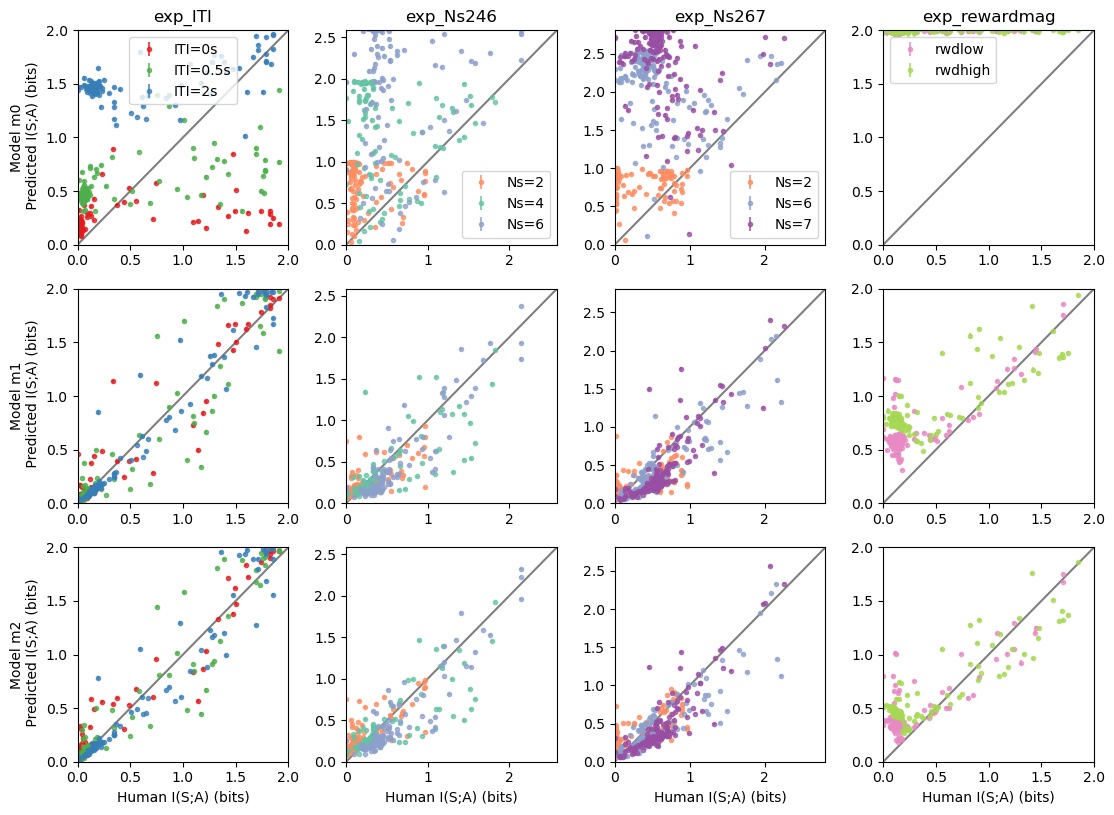

In [114]:

num_samples = 2000
num_chains = 4
alpha=0.5
fig,ax = plt.subplots(3,4,figsize=(15*3/4,11*3/4))
model_names = ["m0","m1","m2"]
dataset_ymaxs = np.array([2,np.log2(6), np.log2(7), 2])
for model_idx in range(len(model_names)):
    model_name = model_names[model_idx]
    print(model_name)
    
    for dataset_idx in range(len(dataset_names)): 
        dataset_ymax = dataset_ymaxs[dataset_idx]
        dataset_name = dataset_names[dataset_idx]
        [n_subj,n_cond] = datasets_dict[dataset_name]["complexity"].shape
        print(n_subj)
        complexity_predictions_mean = np.zeros((n_subj,n_cond))
        complexity_predictions_sem = np.zeros((n_subj,n_cond))
        for subj in range(n_subj):
            with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_"+model_name+".pkl"), "rb") as f:
                a = pickle.load(f)
                predictions = a["predictions"]
            complexity_predictions_mean[subj,:] = np.mean(predictions,axis=0)
            complexity_predictions_sem[subj,:] = np.std(predictions,axis=0,ddof=1)/np.sqrt(num_samples*num_chains)

        complexity_humans = datasets_dict[dataset_name]["complexity"]
        for cond in range(n_cond):
            ax[model_idx,dataset_idx].errorbar(complexity_humans[0:n_subj,cond], complexity_predictions_mean[0:n_subj,cond], yerr=complexity_predictions_sem[0:n_subj,cond], fmt=".", color=colormaps[dataset_name][cond,:], alpha=0.75, label=cond_names[dataset_idx][cond])
        ax[model_idx,dataset_idx].plot([0,dataset_ymax],[0,dataset_ymax],"k-", alpha=0.5)
        ax[0,dataset_idx].legend()
        ax[model_idx,dataset_idx].set_xlim([0,dataset_ymax])
        ax[model_idx,dataset_idx].set_ylim([0,dataset_ymax])
        if(dataset_idx==0):
            ax[model_idx,dataset_idx].set_ylabel("Model "+model_name+"\n Predicted I(S;A) (bits)")
#         else:   
#             ax[model_idx,dataset_idx].set_ylabel("Predicted I(S;A) (bits)")
        ax[len(model_names)-1,dataset_idx].set_xlabel("Human I(S;A) (bits)")
        ax[0,dataset_idx].set_title(dataset_name)
fig.tight_layout()
plt.savefig(os.path.join(figpath, "individual_fits_allexps_models.png"), dpi=300)
plt.show()

# LOO model comparison

In [80]:
num_samples = 2000
num_chains = 4
alpha=0.5

model_names = ["m0","m1","m2"]
n_models = len(model_names)
LOO_subjs_models = {}
for dataset_idx in range(len(dataset_names)): 
    dataset_name = dataset_names[dataset_idx]
    [n_subj,n_cond] = datasets_dict[dataset_name]["complexity"].shape
    LOO_subjs = np.zeros((n_subj,n_models))

    for subj in range(n_subj):
        for model_idx in range(n_models):
            with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_"+model_names[model_idx]+".pkl"), "rb") as f:
                a = pickle.load(f)
                loo = a["loo_result"]
            LOO_subjs[subj,model_idx] = loo.elpd_loo
    LOO_subjs_models[dataset_name] = LOO_subjs
    [t_stat, t_pval01] = scipy.stats.ttest_rel(LOO_subjs[:,0], LOO_subjs[:,1])
    [t_stat, t_pval12] = scipy.stats.ttest_rel(LOO_subjs[:,1], LOO_subjs[:,2])
    print("Dataset:",dataset_name, ", LOOs =", np.sum(LOO_subjs,axis=0),", p01 =", np.round(t_pval01, 5),", p12 =", np.round(t_pval12, 5))
    

Dataset: exp_ITI , LOOs = [-403.64790821  133.89986563  161.79164314] , p01 = 0.0 , p12 = 0.00175
Dataset: exp_Ns246 , LOOs = [-417.56321716 -141.57054567 -104.75170231] , p01 = 0.0 , p12 = 0.00086
Dataset: exp_Ns267 , LOOs = [-862.01065969 -256.31900406 -222.3514576 ] , p01 = 0.0 , p12 = 0.00451
Dataset: exp_rewardmag , LOOs = [-520.38286209 -276.13136148 -149.30918932] , p01 = 0.0 , p12 = 0.0


## Draft code from now on: Visualize MCMC trace and param distributions

(300, 1)
m2
97
99
153
119


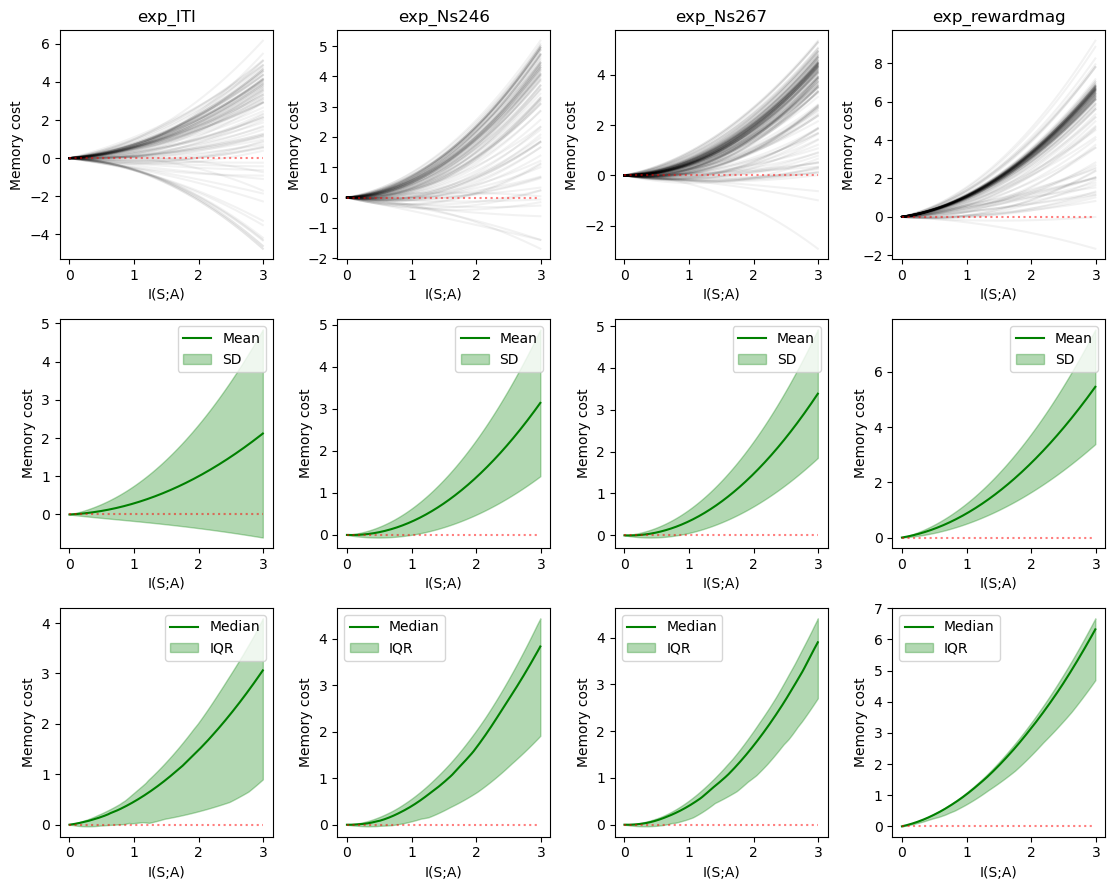

In [162]:
r_grid = np.arange(0,3,0.01)[:,None]
print(r_grid.shape)
num_samples = 2000
num_chains = 4
alpha=0.5
fig,ax = plt.subplots(3,4,figsize=(15*3/4,9))
model_names = ["m2"]
for model_idx in range(len(model_names)):
    model_name = model_names[model_idx]
    print(model_name)
    
    for dataset_idx in range(len(dataset_names)): 
        dataset_ymax = dataset_ymaxs[dataset_idx]
        dataset_name = dataset_names[dataset_idx]
        [n_subj,n_cond] = datasets_dict[dataset_name]["complexity"].shape
        print(n_subj)
        k_inds_mean = np.zeros((1,n_subj))
        quad_inds_mean = np.zeros((1,n_subj))
        roots_mean = np.zeros((n_subj,2))
        for subj in range(n_subj):
            with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_"+model_name+".pkl"), "rb") as f:
                a = pickle.load(f)
                posterior_samples = a["posterior_samples"]
            if(not ("m0" in model_name)):
                k_inds = posterior_samples["k_inds"]
                k_inds_mean[:,subj] = np.mean(k_inds,axis=0)
            if(model_name=="m2"):
                quad_inds = posterior_samples["quad_inds"]
                quad_inds_mean[:,subj] = np.mean(quad_inds,axis=0)
        if(model_name=="m0"):
            memorycost_subjs = np.zeros((len(r_grid),n_subj))
        elif(model_name=="m1"):
            memorycost_subjs = k_inds_mean*r_grid
        elif(model_name=="m2"):
            memorycost_subjs = k_inds_mean*r_grid + quad_inds_mean*(r_grid**2)

        memorycost_mean = np.squeeze(np.mean(memorycost_subjs, axis=1))
        memorycost_std = np.std(memorycost_subjs, axis=1, ddof=1) #/np.sqrt(n_subj)
        memorycost_median = np.quantile(memorycost_subjs, 0.5, axis=1)
        memorycost_Q1 = np.quantile(memorycost_subjs, 0.25, axis=1)
        memorycost_Q3 = np.quantile(memorycost_subjs, 0.75, axis=1)
        
        ax[0,dataset_idx].plot(r_grid, memorycost_subjs, color="k", alpha=0.05)
        ax[0,dataset_idx].plot(r_grid, np.zeros((len(r_grid))), "r:", alpha=0.5)
        ax[0,dataset_idx].set_xlabel("I(S;A)")
        ax[0,dataset_idx].set_ylabel("Memory cost")
        ax[0,dataset_idx].set_title(dataset_name)
        
        ax[1,dataset_idx].plot(r_grid, memorycost_mean, "g-", alpha=1, label="Mean")
        ax[1,dataset_idx].fill_between(np.squeeze(r_grid), memorycost_mean-memorycost_std,  memorycost_mean+memorycost_std, color="g", alpha=0.3, label="SD")
        ax[1,dataset_idx].plot(r_grid, np.zeros((len(r_grid))), "r:", alpha=0.5)
        ax[1,dataset_idx].set_xlabel("I(S;A)")
        ax[1,dataset_idx].set_ylabel("Memory cost")
        ax[1,dataset_idx].legend()
        
        ax[2,dataset_idx].plot(r_grid, memorycost_median, "g-", alpha=1, label="Median")
        ax[2,dataset_idx].fill_between(np.squeeze(r_grid), memorycost_Q1, memorycost_Q3, color="g", alpha=0.3, label="IQR")
        ax[2,dataset_idx].plot(r_grid, np.zeros((len(r_grid))), "r:", alpha=0.5)
        ax[2,dataset_idx].set_xlabel("I(S;A)")
        ax[2,dataset_idx].set_ylabel("Memory cost")
        ax[2,dataset_idx].legend()
fig.tight_layout()
plt.show()
            

m0
m1
m2


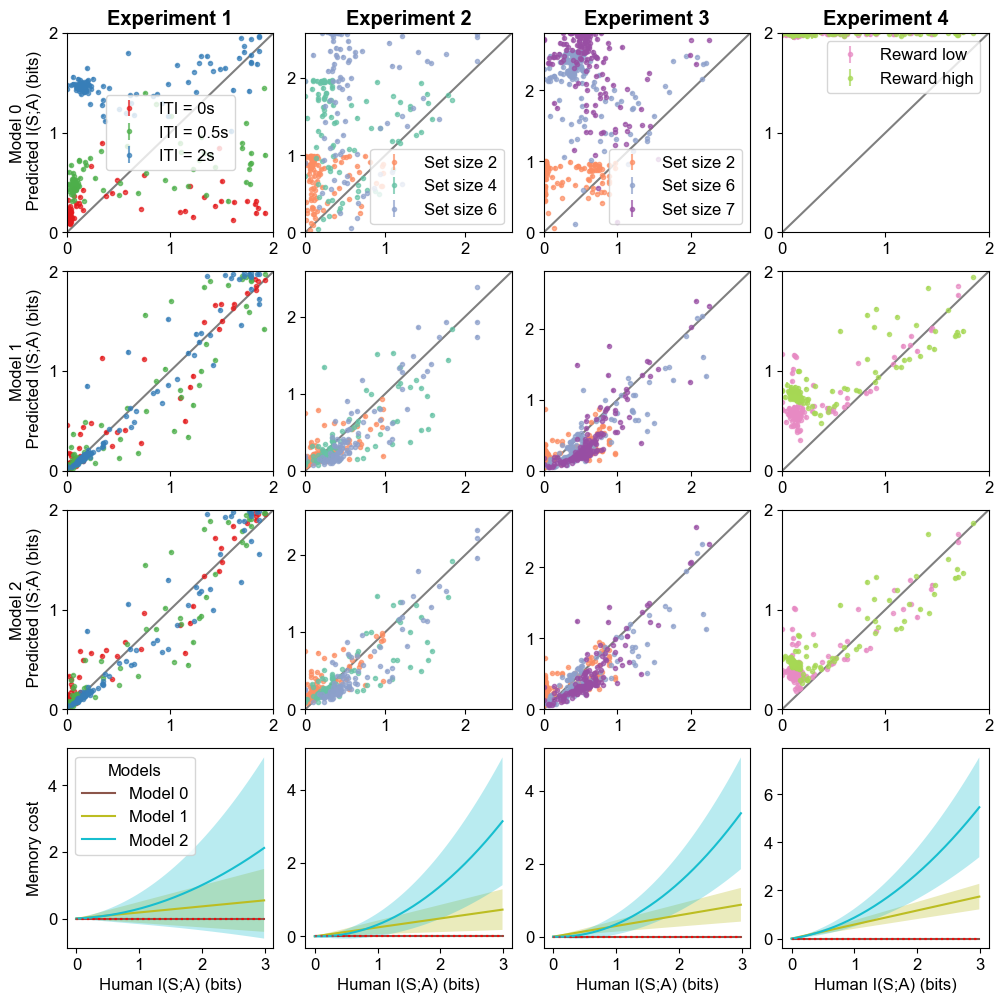

In [11]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams.update({'font.size': 12})

model_names = ["m0","m1","m2"]
dataset_ymaxs = np.array([2,np.log2(6), np.log2(7), 2])
num_samples = 2000
num_chains = 4

r_grid = np.arange(0,3,0.01)[:,None]

alpha=0.5
fig,ax = plt.subplots(4,4,figsize=(10,10))
for model_idx in range(len(model_names)):
    model_name = model_names[model_idx]
    print(model_name)
    
    for dataset_idx in range(len(dataset_names)): 
        dataset_ymax = dataset_ymaxs[dataset_idx]
        dataset_name = dataset_names[dataset_idx]
        [n_subj,n_cond] = datasets_dict[dataset_name]["complexity"].shape
        complexity_predictions_mean = np.zeros((n_subj,n_cond))
        complexity_predictions_sem = np.zeros((n_subj,n_cond))
        k_inds_mean = np.zeros((1,n_subj))
        quad_inds_mean = np.zeros((1,n_subj))
        
        for subj in range(n_subj):
            with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_"+model_name+".pkl"), "rb") as f:
                a = pickle.load(f)
                posterior_samples = a["posterior_samples"]
                predictions = a["predictions"]
            complexity_predictions_mean[subj,:] = np.mean(predictions,axis=0)
            complexity_predictions_sem[subj,:] = np.std(predictions,axis=0,ddof=1)/np.sqrt(num_samples*num_chains)
            
            if(not ("m0" in model_name)):
                k_inds = posterior_samples["k_inds"]
                k_inds_mean[:,subj] = np.mean(k_inds,axis=0)
            if(model_name=="m2"):
                quad_inds = posterior_samples["quad_inds"]
                quad_inds_mean[:,subj] = np.mean(quad_inds,axis=0)
                          
        # Visualize predicted I(S;A)
        complexity_humans = datasets_dict[dataset_name]["complexity"]
#         complexity_predictions_meanmean = np.mean(complexity_predictions_mean, axis=0)
#         complexity_predictions_meansem = np.std(complexity_predictions_mean,axis=0,ddof=1)/np.sqrt(n_subj)
#         for cond in range(n_cond):
#             ax[0,dataset_idx].errorbar(np.mean(complexity_humans[:,cond],axis=0), complexity_predictions_meanmean[cond], yerr=complexity_predictions_meansem[cond], fmt=model_markers[model_idx], color=colormaps[dataset_name][cond,:], alpha=0.5, label=cond_names[dataset_idx][cond])
#         ax[0,dataset_idx].plot([0,dataset_ymax],[0,dataset_ymax],"k-", alpha=0.5)
#         ax[0,dataset_idx].legend()
#         ax[0,dataset_idx].set_xlim([0,dataset_ymax])
#         ax[0,dataset_idx].set_ylim([0,dataset_ymax])
#         if(dataset_idx==0):
#             ax[0,dataset_idx].set_ylabel("Model "+model_name+"\n Predicted I(S;A) (bits)")
#         ax[0,dataset_idx].set_xlabel("Human I(S;A) (bits)")
#         ax[0,dataset_idx].set_title(dataset_name)

        for cond in range(n_cond):
            ax[model_idx,dataset_idx].errorbar(complexity_humans[0:n_subj,cond], complexity_predictions_mean[0:n_subj,cond], yerr=complexity_predictions_sem[0:n_subj,cond], fmt=".", color=colormaps[dataset_name][cond,:], alpha=0.7, label=cond_names[dataset_idx][cond])
        ax[model_idx,dataset_idx].plot([0,dataset_ymax],[0,dataset_ymax],"k-", alpha=0.5)
        ax[0,dataset_idx].legend()
        ax[model_idx,dataset_idx].set_xlim([0,dataset_ymax])
        ax[model_idx,dataset_idx].set_ylim([0,dataset_ymax])
        if(dataset_idx==0):
            ax[model_idx,dataset_idx].set_ylabel("Model "+model_name[-1]+"\n Predicted I(S;A) (bits)")
            ax[model_idx,dataset_idx].set_yticks([0,1,2])
            ax[model_idx,dataset_idx].set_yticklabels([0,1,2])
            ax[model_idx,dataset_idx].set_xticks([0,1,2])
            ax[model_idx,dataset_idx].set_xticklabels([0,1,2])
        if(dataset_idx==3):
            ax[model_idx,dataset_idx].set_yticks([0,1,2])
            ax[model_idx,dataset_idx].set_yticklabels([0,1,2])
            ax[model_idx,dataset_idx].set_xticks([0,1,2])
            ax[model_idx,dataset_idx].set_xticklabels([0,1,2])
            
#         ax[0,dataset_idx].set_title(dataset_name, fontweight='bold')
        ax[0,dataset_idx].set_title("Experiment "+str(dataset_idx+1), fontweight='bold')
                
        # Visualize fitted Memory(I)
        if(model_name=="m0"):
            memorycost_subjs = np.zeros((len(r_grid),n_subj))
        elif(model_name=="m1"):
            memorycost_subjs = k_inds_mean*r_grid
        elif(model_name=="m2"):
            memorycost_subjs = k_inds_mean*r_grid + quad_inds_mean*(r_grid**2)
        memorycost_mean = np.squeeze(np.mean(memorycost_subjs, axis=1))
        memorycost_std = np.std(memorycost_subjs, axis=1, ddof=1) #/np.sqrt(n_subj)        
        ax[3,dataset_idx].plot(r_grid, memorycost_mean, "-", color=colors_models[model_idx,:], alpha=1, label="Model "+str(model_idx))
        ax[3,dataset_idx].fill_between(np.squeeze(r_grid), memorycost_mean-memorycost_std,  memorycost_mean+memorycost_std, color=colors_models[model_idx,:], edgecolor="none", alpha=0.3)
        ax[3,dataset_idx].plot(r_grid, np.zeros((len(r_grid))), "r:", alpha=0.5)
        ax[3,dataset_idx].set_xlabel("Human I(S;A) (bits)")
        ax[3,0].set_ylabel("Memory cost")
        ax[3,0].legend(title="Models", loc="upper left")
        
fig.tight_layout(pad=0.5)
plt.savefig(os.path.join(figpath, "individual_fits_allexps_models2.png"), dpi=300)
plt.savefig(os.path.join(figpath, "Fig4_CogSci.pdf"))
plt.show()
            

# New CogSci figure design

m0
0.063533746
0.046455193
0.03017172
0.0444055
m1
0.063533746
0.046455193
0.03017172
0.0444055
m2
0.063533746
0.046455193
0.03017172
0.0444055


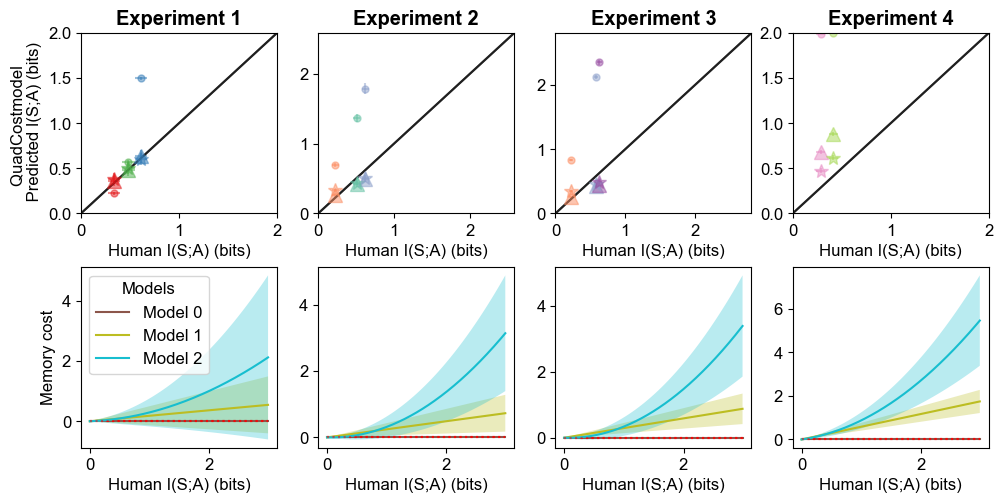

In [26]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams.update({'font.size': 12})

model_names = ["m0","m1","m2"]
model_names_proper = ["NoCost","LinearCost","QuadCost"]
dataset_ymaxs = np.array([2,np.log2(6), np.log2(7), 2])
num_samples = 2000
num_chains = 4

r_grid = np.arange(0,3,0.01)[:,None]

alpha=0.5
fig,ax = plt.subplots(2,4,figsize=(10,5))
for model_idx in range(len(model_names)):
    model_name = model_names[model_idx]
    print(model_name)
    
    for dataset_idx in range(len(dataset_names)): 
        dataset_ymax = dataset_ymaxs[dataset_idx]
        dataset_name = dataset_names[dataset_idx]
        [n_subj,n_cond] = datasets_dict[dataset_name]["complexity"].shape
        complexity_predictions_mean = np.zeros((n_subj,n_cond))
        complexity_predictions_sem = np.zeros((n_subj,n_cond))
        k_inds_mean = np.zeros((1,n_subj))
        quad_inds_mean = np.zeros((1,n_subj))
        
        for subj in range(n_subj):
            with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_"+model_name+".pkl"), "rb") as f:
                a = pickle.load(f)
                posterior_samples = a["posterior_samples"]
                predictions = a["predictions"]
            complexity_predictions_mean[subj,:] = np.mean(predictions,axis=0)
            complexity_predictions_sem[subj,:] = np.std(predictions,axis=0,ddof=1)/np.sqrt(num_samples*num_chains)
            
            if(not ("m0" in model_name)):
                k_inds = posterior_samples["k_inds"]
                k_inds_mean[:,subj] = np.mean(k_inds,axis=0)
            if(model_name=="m2"):
                quad_inds = posterior_samples["quad_inds"]
                quad_inds_mean[:,subj] = np.mean(quad_inds,axis=0)
                          
        # Visualize predicted I(S;A)
        complexity_humans = datasets_dict[dataset_name]["complexity"]
        complexity_humans_sem = np.std(complexity_humans[:,cond],axis=0,ddof=1)/np.sqrt(n_subj)
        complexity_predictions_meanmean = np.mean(complexity_predictions_mean, axis=0)
        complexity_predictions_meansem = np.std(complexity_predictions_mean,axis=0,ddof=1)/np.sqrt(n_subj)
        for cond in range(n_cond):
            ax[0,dataset_idx].errorbar(np.mean(complexity_humans[:,cond],axis=0), complexity_predictions_meanmean[cond], xerr=complexity_humans_sem, yerr=complexity_predictions_meansem[cond], fmt=model_markers[model_idx], markersize=10, color=colormaps[dataset_name][cond,:], alpha=0.5, label=cond_names[dataset_idx][cond])
        ax[0,dataset_idx].plot([0,dataset_ymax],[0,dataset_ymax],"k-", alpha=0.5)
        #ax[0,dataset_idx].legend()
        ax[0,dataset_idx].set_xlim([0,dataset_ymax])
        ax[0,dataset_idx].set_ylim([0,dataset_ymax])
        if(dataset_idx==0):
            ax[0,dataset_idx].set_ylabel(model_names_proper[model_idx]+"model \n Predicted I(S;A) (bits)")
        ax[0,dataset_idx].set_xlabel("Human I(S;A) (bits)")
        ax[0,dataset_idx].set_title(dataset_name)

#         for cond in range(n_cond):
#             ax[model_idx,dataset_idx].errorbar(complexity_humans[0:n_subj,cond], complexity_predictions_mean[0:n_subj,cond], yerr=complexity_predictions_sem[0:n_subj,cond], fmt=".", color=colormaps[dataset_name][cond,:], alpha=0.7, label=cond_names[dataset_idx][cond])
#         ax[model_idx,dataset_idx].plot([0,dataset_ymax],[0,dataset_ymax],"k-", alpha=0.5)
#         ax[0,dataset_idx].legend()
#         ax[model_idx,dataset_idx].set_xlim([0,dataset_ymax])
#         ax[model_idx,dataset_idx].set_ylim([0,dataset_ymax])
#         if(dataset_idx==0):
#             ax[model_idx,dataset_idx].set_ylabel("Model "+model_name[-1]+"\n Predicted I(S;A) (bits)")
#             ax[model_idx,dataset_idx].set_yticks([0,1,2])
#             ax[model_idx,dataset_idx].set_yticklabels([0,1,2])
#             ax[model_idx,dataset_idx].set_xticks([0,1,2])
#             ax[model_idx,dataset_idx].set_xticklabels([0,1,2])
#         if(dataset_idx==3):
#             ax[model_idx,dataset_idx].set_yticks([0,1,2])
#             ax[model_idx,dataset_idx].set_yticklabels([0,1,2])
#             ax[model_idx,dataset_idx].set_xticks([0,1,2])
#             ax[model_idx,dataset_idx].set_xticklabels([0,1,2])
            
#         ax[0,dataset_idx].set_title(dataset_name, fontweight='bold')
        ax[0,dataset_idx].set_title("Experiment "+str(dataset_idx+1), fontweight='bold')
                
        # Visualize fitted Memory(I)
        if(model_name=="m0"):
            memorycost_subjs = np.zeros((len(r_grid),n_subj))
        elif(model_name=="m1"):
            memorycost_subjs = k_inds_mean*r_grid
        elif(model_name=="m2"):
            memorycost_subjs = k_inds_mean*r_grid + quad_inds_mean*(r_grid**2)
        memorycost_mean = np.squeeze(np.mean(memorycost_subjs, axis=1))
        memorycost_std = np.std(memorycost_subjs, axis=1, ddof=1) #/np.sqrt(n_subj)        
        ax[1,dataset_idx].plot(r_grid, memorycost_mean, "-", color=colors_models[model_idx,:], alpha=1, label="Model "+str(model_idx))
        ax[1,dataset_idx].fill_between(np.squeeze(r_grid), memorycost_mean-memorycost_std,  memorycost_mean+memorycost_std, color=colors_models[model_idx,:], edgecolor="none", alpha=0.3)
        ax[1,dataset_idx].plot(r_grid, np.zeros((len(r_grid))), "r:", alpha=0.5)
        ax[1,dataset_idx].set_xlabel("Human I(S;A) (bits)")
        ax[1,0].set_ylabel("Memory cost")
        ax[1,0].legend(title="Models", loc="upper left")
        
fig.tight_layout(pad=0.5)
# plt.savefig(os.path.join(figpath, "individual_fits_allexps_models2.png"), dpi=300)
# plt.savefig(os.path.join(figpath, "Fig4_CogSci.pdf"))
plt.show()
            

0
(3, 97, 3)
1
(3, 99, 3)
2
(3, 153, 3)
3
(3, 119, 2)


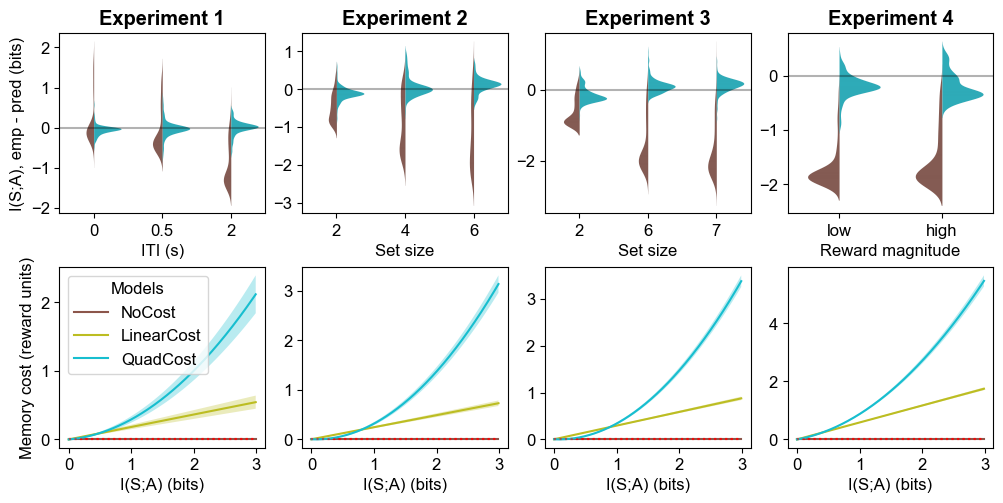

In [9]:
import pandas as pd
cond_meanings = ["ITI (s)","Set size","Set size","Reward magnitude"]
cond_values = [["0","0.5","2"],["2","4","6"],["2","6","7"],["low","high"]]

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams.update({'font.size': 12})

model_names = ["m0","m1","m2"]
model_names_proper = ["NoCost","LinearCost","QuadCost"]
dataset_ymaxs = np.array([2,np.log2(6), np.log2(7), 2])
num_samples = 2000
num_chains = 4

r_grid = np.arange(0,3,0.01)[:,None]

alpha=0.5
fig,ax = plt.subplots(2,4,figsize=(10,5))
    
for dataset_idx in range(len(dataset_names)): 
    print(dataset_idx)
    dataset_ymax = dataset_ymaxs[dataset_idx]
    dataset_name = dataset_names[dataset_idx]
    [n_subj,n_cond] = datasets_dict[dataset_name]["complexity"].shape
            
    complexity_predictions_mean = np.zeros((len(model_names),n_subj,n_cond))
    complexity_predictions_sem = np.zeros((len(model_names),n_subj,n_cond))
    
    for model_idx in range(len(model_names)):
        model_name = model_names[model_idx]
        k_inds_mean = np.zeros((1,n_subj))
        quad_inds_mean = np.zeros((1,n_subj))

        for subj in range(n_subj):
            with open(os.path.join(modelpath,"individual_fits","posterior_samples_"+dataset_name+"_subj"+str(subj)+"_"+model_name+".pkl"), "rb") as f:
                a = pickle.load(f)
                posterior_samples = a["posterior_samples"]
                predictions = a["predictions"]
            complexity_predictions_mean[model_idx, subj,:] = np.mean(predictions,axis=0)
            complexity_predictions_sem[model_idx, subj,:] = np.std(predictions,axis=0,ddof=1)/np.sqrt(num_samples*num_chains)
            
            if(not ("m0" in model_name)):
                k_inds = posterior_samples["k_inds"]
                k_inds_mean[:,subj] = np.mean(k_inds,axis=0)
            if(model_name=="m2"):
                quad_inds = posterior_samples["quad_inds"]
                quad_inds_mean[:,subj] = np.mean(quad_inds,axis=0)
                          
                
        # Visualize fitted Memory(I)
        if(model_name=="m0"):
            memorycost_subjs = np.zeros((len(r_grid),n_subj))
        elif(model_name=="m1"):
            memorycost_subjs = k_inds_mean*r_grid
        elif(model_name=="m2"):
            memorycost_subjs = k_inds_mean*r_grid + quad_inds_mean*(r_grid**2)
        memorycost_mean = np.squeeze(np.mean(memorycost_subjs, axis=1))
        memorycost_std = np.std(memorycost_subjs, axis=1, ddof=1)/np.sqrt(n_subj)        
        ax[1,dataset_idx].plot(r_grid, memorycost_mean, "-", color=colors_models[model_idx,:], alpha=1, label=model_names_proper[model_idx])
        ax[1,dataset_idx].fill_between(np.squeeze(r_grid), memorycost_mean-memorycost_std,  memorycost_mean+memorycost_std, color=colors_models[model_idx,:], edgecolor="none", alpha=0.3)
        ax[1,dataset_idx].plot(r_grid, np.zeros((len(r_grid))), "r:", alpha=0.5)
        ax[1,dataset_idx].set_xlabel("I(S;A) (bits)")
        ax[1,0].set_ylabel("Memory cost (reward units)")
        ax[1,0].legend(title="Models", loc="upper left")
    
    # Visualize leftward biases
    complexity_humans = datasets_dict[dataset_name]["complexity"]
    complexity_optimaldiff_bysubj = complexity_humans[None,:,:] - complexity_predictions_mean
    print(complexity_optimaldiff_bysubj.shape)


    visualized_models = [0,2]
    flattened_data = complexity_optimaldiff_bysubj[visualized_models,:,:].flatten()
    # Generate indices for each level: level_1 (0-2), level_2 (0-96), level_3 (0-2)
    level_1, level_2, level_3 = np.meshgrid(np.arange(len(model_names)-1), np.arange(n_subj), np.arange(n_cond), indexing="ij")
    # Flatten the indices
    level_1 = level_1.flatten()
    level_2 = level_2.flatten()
    level_3 = level_3.flatten()
    level_1_text = []
    for idx in range(len(level_2)):
        level_1_text.append(model_names_proper[visualized_models[level_1[idx]]])
    # Create the DataFrame
    df = pd.DataFrame({
        "Models": level_1_text,
        "Subject": level_2,
        "Condition": level_3,
        "Values": flattened_data.flatten()
    })
    colors_models_alpha = colors_models.copy()
    colors_models_alpha[:,-1] = 0.1
    sns.violinplot(data=df, x="Condition", y="Values", hue="Models", split=True, gap=0.1, width=0.8, inner="quart", linewidth=0.01, palette=colors_models[visualized_models,:], alpha=0.0001, ax=ax[0,dataset_idx])
    ax[0,dataset_idx].legend([], [], frameon=False)
    
    ax[0,dataset_idx].plot([-1,3],[0,0],"k-", alpha=0.3) 
    ax[0,dataset_idx].set_xlim([-0.5,n_cond-0.5])
    
    ax[0,dataset_idx].set_xticklabels(cond_values[dataset_idx]) 
    ax[0,dataset_idx].set_xlabel(cond_meanings[dataset_idx]) 
    ax[0,dataset_idx].set_ylabel("") 
    ax[0,0].set_ylabel("I(S;A), emp - pred (bits)") 

#     for cond in range(n_cond):
#         ax[0,dataset_idx].errorbar(np.mean(complexity_humans[:,cond],axis=0), complexity_predictions_meanmean[cond], yerr=complexity_predictions_meansem[cond], fmt=model_markers[model_idx], color=taset_name][cond,:], alpha=0.5, label=cond_names[dataset_idx][cond])
#     ax[0,dataset_idx].plot([0,dataset_ymax],[0,dataset_ymax],"k-", alpha=0.5)
#     ax[0,dataset_idx].legend()
#     ax[0,dataset_idx].set_xlim([0,dataset_ymax])
#     ax[0,dataset_idx].set_ylim([0,dataset_ymax])
#     if(dataset_idx==0):
#         ax[0,dataset_idx].set_ylabel(model_names_proper[model_idx]+"model \n Predicted I(S;A) (bits)")
#     ax[0,dataset_idx].set_xlabel("Human I(S;A) (bits)")

        
    ax[0,dataset_idx].set_title("Experiment "+str(dataset_idx+1), fontweight='bold')
        
fig.tight_layout(pad=0.5)
plt.savefig(os.path.join(figpath, "individual_fits_allexps_models2.png"), dpi=300)
plt.savefig(os.path.join(figpath, "Fig4_CogSci.pdf"))
plt.show()
            